<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Final Delivery</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201506219 - [up201506219@fe.up.pt](mailto:up201506219@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/>

---

# Code

## Initialization

### Import modules

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling
import matplotlib.pyplot as plt # to display plots
from sklearn.model_selection import KFold, StratifiedKFold # for cross-validation, needs scipy
np.seterr(divide='ignore', invalid='ignore'); # avoid unnecessary messages

### Initialize constants

In [0]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
N_FEATURES   = 22 # the number of features in the dataset
LABEL_INDEX  = 24 # the index in the dataset where the label to predict is
BATCH_SIZE   = 100 # batch size for the train, evaluation and prediction
NUM_CLASSES  = 10 # last layer, num classifications
NUM_ITEMS    = 7195 #Num items in dataset
CROSS_VALIDATION_FUNCTION = StratifiedKFold # use KFold to ignore class representation
ACTIVATION_FUNCTION = tf.nn.relu # default is tf.nn.relu

## Helper Functions

In this section we include functions that are directed at helping the visualisation of the project, the manipulation of data and the creation, training and evaluation of models. Here functions that start with an underscore (_) are purely 'private' helper functions and shouldn't be used or even considered for the evaluation of the report

### Chart Drawing and Visualization functions

In [0]:
from IPython.core.display import display_html, HTML
# function to print string into visual HTML
def html(s, html_tag=None):
    if html_tag:
        s = tag(html_tag, s)
    display_html(HTML(s))
def tag(tag, s):
    return "<%s>%s</%s>" % (tag, s, tag)

In [0]:
from IPython.display import display
# receives paddings and a list @layer_sizes with the number of nodes to draw
def _draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
# helper function to draw a neural network
def drawNN(hidden_layers, figsize=(12, 12), name=None):
    #plt.ioff() #plt.ion()
    plt.tight_layout()
    fig = plt.figure(figsize=figsize);
    ax = fig.gca()
    ax.axis('off')
    _draw_neural_net(ax, .1, .9, .1, .9, [N_FEATURES] + hidden_layers + [NUM_CLASSES])
    display(fig);
    plt.close();

In [0]:
# create an abstract histogram
def _draw_label_distribution(label_column, title_text):
    label_count = pd.Series.value_counts(label_column, normalize=True, sort=False)
    label_count = label_count.sort_index()
    label_count.plot(kind='barh', title=title_text, stacked=True, fontsize=15, figsize=(8,8), color="darkblue" )

# create a histogram with the distribution of species
def draw_species_distribution_chart(df, title_text="Species Dataset Distribution"):
    species_column = df['Species']
    _draw_label_distribution(species_column, title_text)

### Creating Deep Neural Network Models 
 * `my_feature_columns`        - the features that the model should receive as input
 * `inner_layers_architecture` - a list of N hidden layers where N[i] is the number of nodes of the layer i

In [0]:
def create_DNN(my_feature_columns, inner_layers_architecture, save_folder_path=None, num_classes=NUM_CLASSES):
    # Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
    classifier = tf.estimator.DNNClassifier(
            feature_columns = my_feature_columns,
            hidden_units = inner_layers_architecture, # 1:-1 removes the first and last elements of the architecture
            n_classes = num_classes, # num nodes of final layer
            model_dir = save_folder_path, # value None means it will be saved in temp
            activation_fn = ACTIVATION_FUNCTION, # activation function to use
    )
    
    return classifier

### Training Models

In [0]:
SHUFFLE_PARAM = NUM_ITEMS * 10 #df.shape[0] * 10
# helper function to yield a part of the training data to be used by TF's classifier.train method
def _train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(SHUFFLE_PARAM).repeat().batch(BATCH_SIZE)

In [0]:
# Train a model, given the train data and the number of steps
def train_model(classifier, train_x, numeric_train_y, num_steps=1000):
    classifier.train(input_fn=lambda:_train_input_fn(train_x, numeric_train_y), steps=num_steps)

### Evaluating Models

In [0]:
# helper function for the classifier.evaluate method
def _eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [0]:
# Evaluate a model - returns a tuple (eval_results, global_step)
def evaluate_model(classifier, test_x, numeric_test_y):
    return classifier.evaluate(input_fn=lambda:_eval_input_fn(dict(test_x), numeric_test_y))

In [0]:
# predict from a trained model - returns a list of the predictions
def predict_model(classifier, predict_x):
    predictions = list(classifier.predict(input_fn=lambda:_eval_input_fn(dict(predict_x))))
    return [el["class_ids"][0] for el in predictions]

### Dataset Splitting

In [0]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def _convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return [unique_labels.index(l) for l in labels]

In [0]:
def _format_TF_data(train, test):
    # split dataframes into X (features) and y (classes) - use species as label
    train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    
    # for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
    numeric_train_y = _convert_labels_to_number(train_y.iloc[:,0])
    numeric_test_y  = _convert_labels_to_number(test_y.iloc[:,0])
    
    return (train_x, numeric_train_y, test_x, numeric_test_y)

In [0]:
# Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
def get_TF_feature_columns(df):
    data_df = df.iloc[:,:N_FEATURES]
    return [tf.feature_column.numeric_column(key=key) for key in list(data_df)]

#### Simple data splitting into Train and Test data

In [0]:
# returns a single iteration
def simple_data_split_generator(df, labels, train_fraction):
    train=df.sample(frac=train_fraction, random_state=int(time.time()))
    test=df.drop(train.index)
    yield _format_TF_data(train, test) # in a for loop gives one single loop

#### Cross Validation splitting into Train and Test data

In [0]:
def _split_data_by_indices(train_indices, test_indices):
    train = df.iloc[train_indices]
    test = df.iloc[test_indices]
    return _format_TF_data(train, test)

In [0]:
def _get_k_fold_CV_split_indices(df, labels, num_folds = 3):
    k_fold = CROSS_VALIDATION_FUNCTION(n_splits = num_folds, shuffle=True)
    return k_fold.split(df, labels)

In [0]:
def kFoldCV_tf_data_generator(df, labels, train_fraction):
    num_folds = int(1.0 / (1.0 - train_fraction))
    for train_indices, test_indices in _get_k_fold_CV_split_indices(df, labels, num_folds):
        yield(_split_data_by_indices(train_indices, test_indices))

### Hyper-Parameter Tuning
Given a dataset, the respective labels, a function to split the data and another to calculate the number of steps, this function iterates over all the defined architectures in **INNER_LAYERS** and over all the **NUM_STEPS** and over all the  **TRAIN_FRACTIONS** and does the following:
 * Split the data accordingly
 * Train the model
 * Evaluate the model
 * Report the results
 
This can be used for quick comparison of multiple combinations of architectures, number of steps and train fractions, essentially tuning **hyper-parameters**. More can hyper-parameters can be added if needed.

In [0]:
def run_model_iterations(df, labels, data_generator):
    evaluations = []
    for inner_architecture in INNER_LAYERS:
        #drawNN([N_FEATURES] + inner_architecture + [NUM_CLASSES])
        for num_steps in NUM_STEPS:
            for train_fraction in TRAIN_FRACTIONS:
                my_feature_columns = get_TF_feature_columns(df) # seems to need to generate one for each estimator
                classifier = create_DNN(my_feature_columns, inner_architecture)
                (train_x, numeric_train_y, test_x, numeric_test_y) = next(data_generator(df, labels, train_fraction))
                train_model(classifier, train_x, numeric_train_y, num_steps)
                eval_result = evaluate_model(classifier, test_x, numeric_test_y)
                predictions = predict_model(classifier, test_x)
                # evaluation results, only the results of the last evaluation and prediction done on estimator
                evaluations.append({"config": (inner_architecture, train_fraction, num_steps), "eval_result" : eval_result, "prediction": (np.array(predictions), np.array(numeric_test_y))})
    html("Model iterations complete", "h1")
    return evaluations # evaluations can have duplicate 'keys' if k-fold is used

## Evaluation Metrics Used

From the confusion matrix, we derive the number of **true positives** (`TP`), **false positives** (`FP`), **true negatives** (`TN`) and **false negatives** (`FN`).

<img src="report_material/images/multiclass_confusion.png" width="300px" />
<p style="text-align:center">Image of a confusion matrix for a multiclass classification problem</p>

$ precision = \frac{ TP}{TP + FP} $

$ recall  = \frac{TP}{TP + FN} $

$ accuracy = \frac{TP + TN}{TP + FP + FN + TN} $

$ F1-score = 2 \cdot \frac{precision\cdot recall}{precision+ recall} $

Further metrics such as **specificity**, **negative predictive value**, **false positive rate**, **false negative rate** and **false discovery rate** were also calculated, but were not considered when making model decisions

In [0]:
# calculate metrics based on confusion matrix -> precision, recall, f1, ...
def print_metrics(prediction, confusion_matrix):
    predicted, actual = prediction
    
    # get values from confusion matrix for each class
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # false positives
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix) # false negatives
    TP = np.diag(confusion_matrix)  # true positives
    TN = confusion_matrix.sum() - (FP + FN + TP) # true negatives

    # calculate metrics
    TPR = TP/(TP+FN) # Recall, sensitivity, hit rate, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1  =  2 * ((PPV * TPR) / (PPV + TPR)) # f1-score
    ACC = (TP+TN)/(TP+FP+FN+TN) # accuracy
    
    #overall values in percentage
    metrics = tuple(map(lambda v: np.nanmean(v) * 100, [ACC, PPV, TPR, F1]))
    
    # create the table with the statistics
    header = tag("tr", "<th>Species</th><th>Accuracy</th> <th>Precision</th> <th>Recall</th> <th>F1-score</th>")
    body = ""
    footer = tag("tr", "<th>Average</th><th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th>" % metrics)
    for i in range(len(TP)):
        body += tag("tr", "<td>%s</td><td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td>" % (i, ACC[i] * 100, PPV[i] * 100, TPR[i] * 100, F1[i] * 100))
        
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;'>%s%s%s</table>" % (header, body, footer)
    html(table)
    return metrics

In [0]:
# print a confusion matrix after a prediction
def get_confusion_matrix(prediction):
    predicted, actual = prediction
    con_mat = tf.confusion_matrix(actual, predicted, num_classes=NUM_CLASSES)
    with tf.Session():
        return tf.Tensor.eval(con_mat,feed_dict=None, session=None)

### Functions to display and describe the output of a model

In [0]:
def print_configs(configs):
    header = tag("tr", "<th>Hidden Layers</th><th>Training Fraction</th> <th>Number of Steps</th>")
    body = tag("tr", "<th>%s</th><th>%.0f%%</th><th>%s</th>" % (configs[0], configs[1] * 100, configs[2]))
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;text-align=center'>%s%s</table>" % (header, body)
    html(table)

In [0]:
def display_model_results(evaluations):
    # show results, statistics
    print('Num Results: %d' % len(evaluations))
    chart_data = [] # data to create charts later
    for i, e in enumerate(evaluations):
        confusion_matrix = get_confusion_matrix(e["prediction"])
        html("<h2 style='text-align:center'>Iteration %d</h2>" % (i+1))
        
        print_configs(e["config"])
#         drawNN(e["config"][0], (7,7))
        
        html("Confusion Matrix:", "h4")
        html("<br/>")
        print(confusion_matrix)
        
        metrics = print_metrics(e["prediction"], confusion_matrix)
        
        html("<hr>")
        
        chart_data.append((e["config"], metrics)) # config, [ACC, PPV, TPR, F1]
    display_model_comparison(chart_data)

In [0]:
# compare different architectures, train ratios and number of steps
def display_model_comparison(chart_data):
#     print(chart_data)
#     plt.rcParams.update({'font.size': 16})
    for percentage in TRAIN_FRACTIONS:
        plt.figure(figsize=(20,10));
        for layers in INNER_LAYERS:
            x, y = [], []
            for data in chart_data:
                if data[0][0] == layers and data[0][1] == percentage:
                    x.append(data[0][2])
                    y.append(data[1][0])
            plt.plot(x, y, '-', label="%s layers" % layers)


        for steps in NUM_STEPS:
            y = []
            for data in chart_data:
                if data[0][2] == steps and data[0][1] == percentage:
                    y.append(data[1][0])
            plt.plot([steps] * len(y), y, 'x', label="%4d steps"%steps, markersize=16)

        plt.title('Evolution of Accuracy for a training fraction of %.f%%' % (percentage * 100))
        plt.legend(loc='best')
        plt.show()

# Main

### Loading Data

In [26]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FgfTiJIKbkHLg3xtajFrNTK4ef5m0VuT'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()[100:1000]))

Downloaded content "FCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
1,0.152936298220384,-0.105585902844019,0.200721914808566,0.317201062343259,0.260763853131077,0.100944640810053,-0.150062604917616,-0.17112763198601,0.124676436148438,0.188654145822323,-0.0756217229244772,-0.156435925226375,0.0822451152835443,0.135752042383891,-0.0240166450287792,-0.108351107221198,-0.0776225214037558,-0.00956780151914234,0.0576839754007957,0.118680135068692,0.0140384456733697,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,0.171534257314109,-0.0989747371205295,0.268425220827017,0.338671862995453,0.268353099863332,0.0608350871920449,-0.222474640379244,-0.207692670568256,0.170882873543032,0.27095827998887,-0.0950039445276873,-0.254341468381362,0.0227862345814336,0.163320101050209,0.0120222808645159,-0.0909740108032878,-0.0565095219192882,-0.035303356"


In [27]:
# from csv to pandas Dataframe
# df = pd.read_csv(DATASET_PATH)
df = pd.read_csv(io.StringIO(downloaded.GetContentString()))
df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF

print("Got %d examples from the .csv" % df.shape[0])
df.head()

Got 7195 examples from the .csv


,MFCCs_1,MFCCs_2,MFCCs_3,MFCCs_4,MFCCs_5,MFCCs_6,MFCCs_7,MFCCs_8,MFCCs_9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [0]:
# get a mapping of all the labels in the Dataset into its integer values (required for Stratified Cross Validation)
labels = _convert_labels_to_number(df.iloc[:,LABEL_INDEX:LABEL_INDEX+1].iloc[:,0])

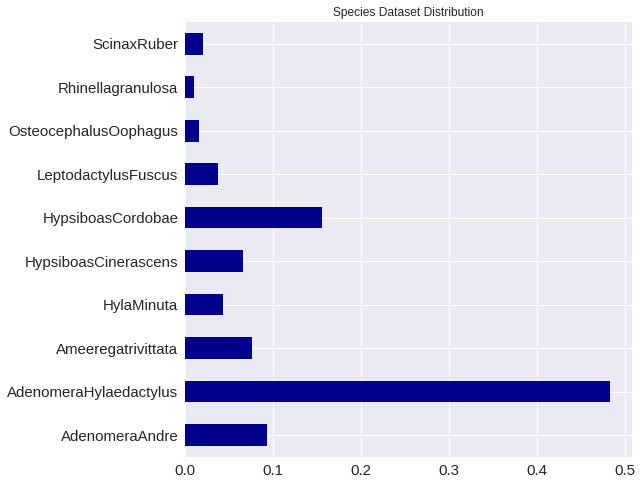

In [29]:
# draw dataset distribution
draw_species_distribution_chart(df)

### Running iterations

In [0]:
### Iterations

# modify here to set model configurations
INNER_LAYERS = [
    [10],
    [100],
    [10, 10],
    [100, 100],
    [10, 10, 10],
    [100, 100, 100],
    [100, 50, 25],
    [25, 50, 100]
]

TRAIN_FRACTIONS = [
    0.8,
    0.5,
]

NUM_STEPS = [
    100, 
    200,
    500,
    1000,
    1500,
    2000
]

### Initial approach to dataset splitting
Random split into train and test

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [0]:
# this may take a while
#evaluations = run_model_iterations(df, labels, simple_data_split_generator)    

In [0]:
# simple data splitting results
#display_model_results(evaluations)

### Cross-Validation approach to dataset splitting
In **k-fold** cross-validation, the original sample is randomly partitioned into k equal size subsamples.

In **stratified k-fold** cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds.

To use one or the other, update the global setting `CROSS_VALIDATION_FUNCTION` in the [Initialize constants](#Initialize-constants) section

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [33]:
# k-fold cross validation
# this may take a while

# adjustment for k-fold: num_total_model_steps = num_steps * num_folds
kfcv_evaluations = run_model_iterations(df, labels, kFoldCV_tf_data_generator)    


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpi0psiy5n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb84115c438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpi0psiy5n/model.ckpt.
INFO:tensorflow:loss = 233.06535, step = 0
INFO:tensorf

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpuikk6oul', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb8411d8e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpuikk6oul/model.ckpt.
INFO:tensorflow:loss = 232.81746, step = 0
INFO:tensorflow:global_step/sec: 148.559
INFO:tens

INFO:tensorflow:loss = 14.425979, step = 1300 (0.648 sec)
INFO:tensorflow:global_step/sec: 159.523
INFO:tensorflow:loss = 25.660776, step = 1400 (0.620 sec)
INFO:tensorflow:Saving checkpoints for 1500 into /tmp/tmp5_rlrwqg/model.ckpt.
INFO:tensorflow:Loss for final step: 25.989754.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-14:06:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5_rlrwqg/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:06:22
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.96257794, average_loss = 0.17335454, global_step = 1500, loss = 16.676706
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5_rlrwqg/model.ckpt-1500
INFO:tens

INFO:tensorflow:loss = 21.730827, step = 800 (0.602 sec)
INFO:tensorflow:global_step/sec: 166.614
INFO:tensorflow:loss = 16.593494, step = 900 (0.602 sec)
INFO:tensorflow:global_step/sec: 165.666
INFO:tensorflow:loss = 19.217186, step = 1000 (0.599 sec)
INFO:tensorflow:global_step/sec: 175.001
INFO:tensorflow:loss = 20.693645, step = 1100 (0.576 sec)
INFO:tensorflow:global_step/sec: 163.322
INFO:tensorflow:loss = 30.43945, step = 1200 (0.608 sec)
INFO:tensorflow:global_step/sec: 166.33
INFO:tensorflow:loss = 18.96334, step = 1300 (0.601 sec)
INFO:tensorflow:global_step/sec: 169.709
INFO:tensorflow:loss = 25.596039, step = 1400 (0.593 sec)
INFO:tensorflow:global_step/sec: 162.993
INFO:tensorflow:loss = 18.398771, step = 1500 (0.610 sec)
INFO:tensorflow:global_step/sec: 163.953
INFO:tensorflow:loss = 14.017045, step = 1600 (0.613 sec)
INFO:tensorflow:global_step/sec: 164.774
INFO:tensorflow:loss = 19.481743, step = 1700 (0.608 sec)
INFO:tensorflow:global_step/sec: 164.273
INFO:tensorflow

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmphyiq0i_w/model.ckpt.
INFO:tensorflow:loss = 249.37234, step = 0
INFO:tensorflow:global_step/sec: 154.001
INFO:tensorflow:loss = 20.931236, step = 100 (0.656 sec)
INFO:tensorflow:global_step/sec: 162.509
INFO:tensorflow:loss = 12.107113, step = 200 (0.616 sec)
INFO:tensorflow:global_step/sec: 163.61
INFO:tensorflow:loss = 9.2437725, step = 300 (0.611 sec)
INFO:tensorflow:global_step/sec: 176.013
INFO:tensorflow:loss = 12.000462, step = 400 (0.566 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmphyiq0i_w/model.ckpt.
INFO:tensorflow:Loss for final step: 4.3813424.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-14:07:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphyiq0i_w/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmprwgnf_sv/model.ckpt.
INFO:tensorflow:loss = 215.56421, step = 0
INFO:tensorflow:global_step/sec: 153.818
INFO:tensorflow:loss = 10.60368, step = 100 (0.656 sec)
INFO:tensorflow:global_step/sec: 158.978
INFO:tensorflow:loss = 24.91969, step = 200 (0.630 sec)
INFO:tensorflow:global_step/sec: 161.2
INFO:tensorflow:loss = 6.6704626, step = 300 (0.620 sec)
INFO:tensorflow:global_step/sec: 165.528
INFO:tensorflow:loss = 9.822303, step = 400 (0.605 sec)
INFO:tensorflow:global_step/sec: 158.019
INFO:tensorflow:loss = 5.438653, step = 500 (0.632 sec)
INFO:tensorflow:global_step/sec: 153.609
INFO:tensorflow:loss = 10.270342, step = 600 (0.650 sec)
INFO:tensorflow:global_step/sec: 162.647
INFO:tensorflow:loss = 7.1859426, step = 700 (0.616 sec)
INFO:tensorflow:global_step/sec: 175.829
INFO:tensorflow:loss = 3.7956686, step = 

INFO:tensorflow:loss = 223.55504, step = 0
INFO:tensorflow:global_step/sec: 152.2
INFO:tensorflow:loss = 25.156769, step = 100 (0.663 sec)
INFO:tensorflow:global_step/sec: 162.421
INFO:tensorflow:loss = 18.212599, step = 200 (0.614 sec)
INFO:tensorflow:global_step/sec: 164.543
INFO:tensorflow:loss = 15.939178, step = 300 (0.606 sec)
INFO:tensorflow:global_step/sec: 162.995
INFO:tensorflow:loss = 9.483749, step = 400 (0.618 sec)
INFO:tensorflow:global_step/sec: 163.546
INFO:tensorflow:loss = 9.793248, step = 500 (0.611 sec)
INFO:tensorflow:global_step/sec: 161.066
INFO:tensorflow:loss = 9.107845, step = 600 (0.621 sec)
INFO:tensorflow:global_step/sec: 160.463
INFO:tensorflow:loss = 6.8194575, step = 700 (0.621 sec)
INFO:tensorflow:global_step/sec: 163.232
INFO:tensorflow:loss = 6.577659, step = 800 (0.613 sec)
INFO:tensorflow:global_step/sec: 163.545
INFO:tensorflow:loss = 3.6831863, step = 900 (0.611 sec)
INFO:tensorflow:global_step/sec: 167.909
INFO:tensorflow:loss = 7.005392, step = 

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpti_wph12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb839254eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpti_wph12/model.ckpt.
INFO:tensorflow:loss = 232.2755, step = 0
INFO:tensorflow:global_step/sec: 148.422
INFO:tenso

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmmb9muvs/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxzro5am0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb81899d1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Ru

INFO:tensorflow:loss = 15.182932, step = 1700 (0.644 sec)
INFO:tensorflow:global_step/sec: 156.446
INFO:tensorflow:loss = 21.965982, step = 1800 (0.640 sec)
INFO:tensorflow:global_step/sec: 156.67
INFO:tensorflow:loss = 11.505808, step = 1900 (0.642 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp6lqon8rt/model.ckpt.
INFO:tensorflow:Loss for final step: 6.255745.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-14:10:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp6lqon8rt/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:10:16
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.95703393, average_loss = 0.17463703, global_step = 2000, loss = 16.800083
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph wa

INFO:tensorflow:Restoring parameters from /tmp/tmpvthq6csz/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:10:44
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.97020096, average_loss = 0.13880156, global_step = 200, loss = 13.35271
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvthq6csz/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1aca1sw2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tens

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp6m2z3jav/model.ckpt.
INFO:tensorflow:loss = 224.89474, step = 0
INFO:tensorflow:global_step/sec: 143.5
INFO:tensorflow:loss = 23.522118, step = 100 (0.699 sec)
INFO:tensorflow:global_step/sec: 158.779
INFO:tensorflow:loss = 9.003619, step = 200 (0.634 sec)
INFO:tensorflow:global_step/sec: 157.079
INFO:tensorflow:loss = 4.703548, step = 300 (0.633 sec)
INFO:tensorflow:global_step/sec: 158.374
INFO:tensorflow:loss = 4.379434, step = 400 (0.634 sec)
INFO:tensorflow:global_step/sec: 161.707
INFO:tensorflow:loss = 6.3230896, step = 500 (0.619 sec)
INFO:tensorflow:global_step/sec: 157.084
INFO:tensorflow:loss = 2.6791334, step = 600 (0.639 sec)
INFO:tensorflow:global_step/sec: 148.494
INFO:tensorflow:loss 

INFO:tensorflow:loss = 3.200847, step = 600 (0.641 sec)
INFO:tensorflow:global_step/sec: 153.512
INFO:tensorflow:loss = 1.5678657, step = 700 (0.651 sec)
INFO:tensorflow:global_step/sec: 162.942
INFO:tensorflow:loss = 0.39522028, step = 800 (0.615 sec)
INFO:tensorflow:global_step/sec: 157.916
INFO:tensorflow:loss = 2.174554, step = 900 (0.637 sec)
INFO:tensorflow:global_step/sec: 156.323
INFO:tensorflow:loss = 0.83916765, step = 1000 (0.637 sec)
INFO:tensorflow:global_step/sec: 155.289
INFO:tensorflow:loss = 0.6445344, step = 1100 (0.645 sec)
INFO:tensorflow:global_step/sec: 165.351
INFO:tensorflow:loss = 0.91470546, step = 1200 (0.605 sec)
INFO:tensorflow:global_step/sec: 155.43
INFO:tensorflow:loss = 0.81812423, step = 1300 (0.640 sec)
INFO:tensorflow:global_step/sec: 154.133
INFO:tensorflow:loss = 2.058055, step = 1400 (0.651 sec)
INFO:tensorflow:global_step/sec: 156.297
INFO:tensorflow:loss = 0.2874471, step = 1500 (0.644 sec)
INFO:tensorflow:global_step/sec: 167.682
INFO:tensorflo

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpz0t1kj20/model.ckpt.
INFO:tensorflow:loss = 228.77174, step = 0
INFO:tensorflow:global_step/sec: 136.269
INFO:tensorflow:loss = 68.528, step = 100 (0.738 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpz0t1kj20/model.ckpt.
INFO:tensorflow:Loss for final step: 14.698918.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-14:12:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpz0t1kj20/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:12:32
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.9300069, average_loss = 0.2659144, global_step = 200, loss = 25.580965
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was f

INFO:tensorflow:Restoring parameters from /tmp/tmpu5qwrs6_/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphzg3sj0g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb81896c240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:

INFO:tensorflow:loss = 23.385185, step = 200 (0.664 sec)
INFO:tensorflow:global_step/sec: 150.13
INFO:tensorflow:loss = 18.381353, step = 300 (0.666 sec)
INFO:tensorflow:global_step/sec: 163.207
INFO:tensorflow:loss = 19.486864, step = 400 (0.612 sec)
INFO:tensorflow:global_step/sec: 145.645
INFO:tensorflow:loss = 56.842125, step = 500 (0.687 sec)
INFO:tensorflow:global_step/sec: 150.051
INFO:tensorflow:loss = 12.453662, step = 600 (0.669 sec)
INFO:tensorflow:global_step/sec: 148.002
INFO:tensorflow:loss = 13.395417, step = 700 (0.673 sec)
INFO:tensorflow:global_step/sec: 160.816
INFO:tensorflow:loss = 14.164236, step = 800 (0.619 sec)
INFO:tensorflow:global_step/sec: 140.29
INFO:tensorflow:loss = 4.885066, step = 900 (0.716 sec)
INFO:tensorflow:global_step/sec: 152.432
INFO:tensorflow:loss = 14.196817, step = 1000 (0.658 sec)
INFO:tensorflow:global_step/sec: 150.545
INFO:tensorflow:loss = 8.969797, step = 1100 (0.664 sec)
INFO:tensorflow:global_step/sec: 159.465
INFO:tensorflow:loss =

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpo8ef8gh6/model.ckpt.
INFO:tensorflow:loss = 224.51231, step = 0
INFO:tensorflow:global_step/sec: 143.275
INFO:tensorflow:loss = 13.215229, step = 100 (0.706 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpo8ef8gh6/model.ckpt.
INFO:tensorflow:Loss for final step: 11.205356.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-14:14:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpo8ef8gh6/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:14:22
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.96257794,

INFO:tensorflow:Restoring parameters from /tmp/tmp7_lz9s92/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:14:51
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.983368, average_loss = 0.057315595, global_step = 1000, loss = 5.5137606
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7_lz9s92/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphmcbhh_8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <

INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.98499167, average_loss = 0.07345019, global_step = 1500, loss = 7.340939
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphi60yp4v/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsn5ugjra', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb818605208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_repl

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8zsj3uqq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb8410e0a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp8zsj3uqq/model.ckpt.
INFO:tensor

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxks_qwmx/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7078pb8p', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb839630198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Run

INFO:tensorflow:loss = 1.4224705, step = 500 (0.655 sec)
INFO:tensorflow:global_step/sec: 144.845
INFO:tensorflow:loss = 3.6488006, step = 600 (0.691 sec)
INFO:tensorflow:global_step/sec: 144.855
INFO:tensorflow:loss = 2.1298316, step = 700 (0.690 sec)
INFO:tensorflow:global_step/sec: 155.45
INFO:tensorflow:loss = 6.8641376, step = 800 (0.643 sec)
INFO:tensorflow:global_step/sec: 157.004
INFO:tensorflow:loss = 0.9659917, step = 900 (0.637 sec)
INFO:tensorflow:global_step/sec: 161.622
INFO:tensorflow:loss = 4.3023973, step = 1000 (0.623 sec)
INFO:tensorflow:global_step/sec: 151.978
INFO:tensorflow:loss = 1.5943228, step = 1100 (0.658 sec)
INFO:tensorflow:global_step/sec: 154.273
INFO:tensorflow:loss = 2.689365, step = 1200 (0.650 sec)
INFO:tensorflow:global_step/sec: 155.14
INFO:tensorflow:loss = 0.63633764, step = 1300 (0.646 sec)
INFO:tensorflow:global_step/sec: 154.214
INFO:tensorflow:loss = 0.79887533, step = 1400 (0.647 sec)
INFO:tensorflow:Saving checkpoints for 1500 into /tmp/tmp

INFO:tensorflow:loss = 239.71185, step = 0
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpa8443iig/model.ckpt.
INFO:tensorflow:Loss for final step: 18.197393.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-14:17:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpa8443iig/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:17:55
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.9480249, average_loss = 0.18143867, global_step = 100, loss = 17.454401
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpa8443iig/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:ten

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-14:18:23
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.9766537, average_loss = 0.0865899, global_step = 500, loss = 8.65418
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0lkm355r/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm6tzbo7r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb8396305f8>, '_ta

INFO:tensorflow:loss = 229.94186, step = 0
INFO:tensorflow:global_step/sec: 139.615
INFO:tensorflow:loss = 29.283125, step = 100 (0.723 sec)
INFO:tensorflow:global_step/sec: 149.882
INFO:tensorflow:loss = 9.677383, step = 200 (0.662 sec)
INFO:tensorflow:global_step/sec: 150.196
INFO:tensorflow:loss = 6.2362986, step = 300 (0.671 sec)
INFO:tensorflow:global_step/sec: 143.492
INFO:tensorflow:loss = 11.913669, step = 400 (0.692 sec)
INFO:tensorflow:global_step/sec: 153.326
INFO:tensorflow:loss = 1.9618537, step = 500 (0.658 sec)
INFO:tensorflow:global_step/sec: 148.73
INFO:tensorflow:loss = 6.93923, step = 600 (0.675 sec)
INFO:tensorflow:global_step/sec: 152.051
INFO:tensorflow:loss = 2.1863046, step = 700 (0.655 sec)
INFO:tensorflow:global_step/sec: 152.403
INFO:tensorflow:loss = 4.333575, step = 800 (0.654 sec)
INFO:tensorflow:global_step/sec: 155.421
INFO:tensorflow:loss = 3.0960565, step = 900 (0.640 sec)
INFO:tensorflow:global_step/sec: 159.718
INFO:tensorflow:loss = 1.3337123, step 

Model iterations complete

Num Results: 96


Iteration 1

Hidden Layers,Training Fraction,Number of Steps
[10],80%,100


Confusion Matrix:

[[ 23   0   0   0   9   1   0   9   0  20]
 [  0   0   0   9   0  14   0   0   0   0]
 [  0   0   0   0   0   6   0   8   0   0]
 [  0   0   0  89   0   5   0   1   0   0]
 [  0   0   0   0 695   0   0   1   0   0]
 [  0   0   0   1   0 224   0   0   0   0]
 [  1   0   0   6   5  15   1   1   0   1]
 [  0   0   0   3   0   0   0 124   0   8]
 [  0   0   0   0   0  54   0   0   0   0]
 [  1   0   0   0   0   1   0  39   0  68]]


Species,Accuracy,Precision,Recall,F1-score
0,97.16%,92.00%,37.10%,52.87%
1,98.41%,nan%,0.00%,nan%
2,99.03%,nan%,0.00%,nan%
3,98.27%,82.41%,93.68%,87.68%
4,98.96%,98.03%,99.86%,98.93%
5,93.28%,70.00%,99.56%,82.20%
6,97.99%,100.00%,3.33%,6.45%
7,95.15%,67.76%,91.85%,77.99%
8,96.26%,nan%,0.00%,nan%
9,95.15%,70.10%,62.39%,66.02%


Iteration 2

Hidden Layers,Training Fraction,Number of Steps
[10],50%,100


Confusion Matrix:

[[  45    0    0    0   27    7    0   25    0   51]
 [   0    0    0   14    0   41    0    2    0    0]
 [   0    0    0    0    0   30    0    4    0    0]
 [   0    0    0  220    0    8    0    8    0    0]
 [   0    0    0    1 1736    2    0    0    0    0]
 [   1    0    0    4    0  556    0    0    0    0]
 [   1    0    0    3   17   38    0    2    0   13]
 [   0    0    0    3    0    3    0  315    0   15]
 [   8    0    0    1    1  112    0   10    3    0]
 [   0    0    0    0    0    6    0   75    0  190]]


Species,Accuracy,Precision,Recall,F1-score
0,96.66%,81.82%,29.03%,42.86%
1,98.42%,nan%,0.00%,nan%
2,99.06%,nan%,0.00%,nan%
3,98.83%,89.43%,93.22%,91.29%
4,98.67%,97.47%,99.83%,98.64%
5,93.00%,69.24%,99.11%,81.52%
6,97.94%,nan%,0.00%,nan%
7,95.91%,71.43%,93.75%,81.08%
8,96.33%,100.00%,2.22%,4.35%
9,95.55%,70.63%,70.11%,70.37%


Iteration 3

Hidden Layers,Training Fraction,Number of Steps
[10],80%,200


Confusion Matrix:

[[ 31   0   0   0  15   2   0   9   0   5]
 [  0   1   0   6   0  15   0   1   0   0]
 [  0   0   0   0   0  12   0   0   1   1]
 [  0   0   0  92   0   2   0   0   1   0]
 [  0   0   0   1 693   1   0   0   0   1]
 [  0   0   0   0   0 224   0   0   1   0]
 [  3   0   0   2   0  13  12   0   0   0]
 [  0   1   0   1   0   0   0 127   0   6]
 [  1   0   0   0   0   4   0   3  46   0]
 [  5   0   0   0   0   4   0   1   0  99]]


Species,Accuracy,Precision,Recall,F1-score
0,97.23%,77.50%,50.00%,60.78%
1,98.41%,50.00%,4.35%,8.00%
2,99.03%,nan%,0.00%,nan%
3,99.10%,90.20%,96.84%,93.40%
4,98.75%,97.88%,99.57%,98.72%
5,96.26%,80.87%,99.56%,89.24%
6,98.75%,100.00%,40.00%,57.14%
7,98.48%,90.07%,94.07%,92.03%
8,99.24%,93.88%,85.19%,89.32%
9,98.41%,88.39%,90.83%,89.59%


Iteration 4

Hidden Layers,Training Fraction,Number of Steps
[10],50%,200


Confusion Matrix:

[[  63    0    0    0   27    0    0   18    0   47]
 [   0    0    0   16    0   39    0    1    1    0]
 [   0    0    0    2    0   16    0    9    1    6]
 [   0    0    0  224    0   11    0    1    0    0]
 [   4    0    0    0 1732    1    0    0    0    2]
 [   1    0    0    3    4  545    0    0    8    0]
 [   0    0    0   12   23   19    5    0    0   15]
 [   0    0    0    2    0    4    0  319    0   11]
 [   0    0    0    0    1   20    0    3  111    0]
 [   4    0    0    0    0    2    0    3    0  262]]


Species,Accuracy,Precision,Recall,F1-score
0,97.19%,87.50%,40.65%,55.51%
1,98.42%,nan%,0.00%,nan%
2,99.06%,nan%,0.00%,nan%
3,98.69%,86.49%,94.92%,90.51%
4,98.28%,96.92%,99.60%,98.24%
5,96.44%,82.95%,97.15%,89.49%
6,98.08%,100.00%,6.76%,12.66%
7,98.55%,90.11%,94.94%,92.46%
8,99.06%,91.74%,82.22%,86.72%
9,97.50%,76.38%,96.68%,85.34%


Iteration 5

Hidden Layers,Training Fraction,Number of Steps
[10],80%,500


Confusion Matrix:

[[ 35   0   0   0   7   0   1   8   0  11]
 [  0   5   0   9   0   6   0   2   1   0]
 [  0   1   0   0   0   4   0   3   1   5]
 [  0   0   0  93   0   0   0   1   1   0]
 [  0   0   0   2 693   1   0   0   0   0]
 [  0   0   0   3   0 221   0   0   1   0]
 [  4   1   0   0   0   4  20   0   0   1]
 [  0   0   0   0   0   0   0 134   0   1]
 [  2   0   0   3   0   1   0   0  48   0]
 [  1   0   0   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,97.64%,83.33%,56.45%,67.31%
1,98.61%,71.43%,21.74%,33.33%
2,99.03%,nan%,0.00%,nan%
3,98.68%,84.55%,97.89%,90.73%
4,99.31%,99.00%,99.57%,99.28%
5,98.61%,93.25%,98.22%,95.67%
6,99.24%,95.24%,66.67%,78.43%
7,98.96%,90.54%,99.26%,94.70%
8,99.31%,92.31%,88.89%,90.57%
9,98.68%,85.71%,99.08%,91.91%


Iteration 6

Hidden Layers,Training Fraction,Number of Steps
[10],50%,500


Confusion Matrix:

[[  70    0    0    0   20    1    0   32    0   32]
 [   0   20    0   11    0   20    2    1    3    0]
 [   0    0    0    2    0    4    1   23    1    3]
 [   0    1    0  226    0    0    0    2    7    0]
 [   5    0    0    1 1730    3    0    0    0    0]
 [   0    0    0    3    2  546    0    0   10    0]
 [   2    1    0   13    0    5   38    0    0   15]
 [   0    1    0    3    0    3    0  313    0   16]
 [   1    0    0    3    1    9    0    8  113    0]
 [   2    0    0    0    0    0    0    8    0  261]]


Species,Accuracy,Precision,Recall,F1-score
0,97.36%,87.50%,45.16%,59.57%
1,98.89%,86.96%,35.09%,50.00%
2,99.06%,nan%,0.00%,nan%
3,98.72%,86.26%,95.76%,90.76%
4,99.11%,98.69%,99.48%,99.08%
5,98.33%,92.39%,97.33%,94.79%
6,98.92%,92.68%,51.35%,66.09%
7,97.30%,80.88%,93.15%,86.58%
8,98.80%,84.33%,83.70%,84.01%
9,97.89%,79.82%,96.31%,87.29%


Iteration 7

Hidden Layers,Training Fraction,Number of Steps
[10],80%,1000


Confusion Matrix:

[[ 32   0   0   0  15   1   0   7   0   7]
 [  0  14   0   4   0   4   1   0   0   0]
 [  0   0   7   1   0   0   3   0   2   1]
 [  0   3   0  91   0   1   0   0   0   0]
 [  1   0   0   1 692   0   2   0   0   0]
 [  1   0   0   2   1 217   0   0   4   0]
 [  2   2   0   3   0   0  19   1   0   3]
 [  0   1   0   1   0   2   0 124   0   7]
 [  0   0   0   3   0   1   0   1  48   1]
 [  6   0   0   0   0   0   0   3   0 100]]


Species,Accuracy,Precision,Recall,F1-score
0,97.23%,76.19%,51.61%,61.54%
1,98.96%,70.00%,60.87%,65.12%
2,99.51%,100.00%,50.00%,66.67%
3,98.68%,85.85%,95.79%,90.55%
4,98.61%,97.74%,99.43%,98.58%
5,98.82%,96.02%,96.44%,96.23%
6,98.82%,76.00%,63.33%,69.09%
7,98.41%,91.18%,91.85%,91.51%
8,99.17%,88.89%,88.89%,88.89%
9,98.06%,84.03%,91.74%,87.72%


Iteration 8

Hidden Layers,Training Fraction,Number of Steps
[10],50%,1000


Confusion Matrix:

[[  67    0    0    0   22    6    0   20    0   40]
 [   0   26    0   11    0   15    2    2    1    0]
 [   2    0    5    1    0    0    2    9    2   13]
 [   0    6    0  226    0    2    1    0    1    0]
 [   5    0    1    1 1728    3    0    0    0    1]
 [   0    0    0    1    1  554    0    0    5    0]
 [   3    0    0    7    0    2   60    2    0    0]
 [   1    1    0    1    0    2    0  321    0   10]
 [   2    0    0    4    0    5    0    4  120    0]
 [   4    0    0    0    0    0    1    6    0  260]]


Species,Accuracy,Precision,Recall,F1-score
0,97.08%,79.76%,43.23%,56.07%
1,98.94%,78.79%,45.61%,57.78%
2,99.17%,83.33%,14.71%,25.00%
3,99.00%,89.68%,95.76%,92.62%
4,99.06%,98.69%,99.37%,99.03%
5,98.83%,94.06%,98.75%,96.35%
6,99.44%,90.91%,81.08%,85.71%
7,98.39%,88.19%,95.54%,91.71%
8,99.33%,93.02%,88.89%,90.91%
9,97.92%,80.25%,95.94%,87.39%


Iteration 9

Hidden Layers,Training Fraction,Number of Steps
[10],80%,1500


Confusion Matrix:

[[ 46   0   0   0   5   0   0   6   0   5]
 [  0  18   0   3   0   2   0   0   0   0]
 [  0   0  13   0   0   0   0   0   1   0]
 [  0   3   0  91   0   0   0   0   1   0]
 [  0   0   0   0 695   0   0   0   0   1]
 [  1   0   0   0   0 218   0   0   6   0]
 [  0   0   0   0   0   1  29   0   0   0]
 [  0   1   0   0   0   1   0 126   0   7]
 [  3   0   0   1   0   3   0   0  47   0]
 [  2   0   0   0   0   1   0   0   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,98.48%,88.46%,74.19%,80.70%
1,99.38%,81.82%,78.26%,80.00%
2,99.93%,100.00%,92.86%,96.30%
3,99.45%,95.79%,95.79%,95.79%
4,99.58%,99.29%,99.86%,99.57%
5,98.96%,96.46%,96.89%,96.67%
6,99.93%,100.00%,96.67%,98.31%
7,98.96%,95.45%,93.33%,94.38%
8,98.96%,85.45%,87.04%,86.24%
9,98.89%,89.08%,97.25%,92.98%


Iteration 10

Hidden Layers,Training Fraction,Number of Steps
[10],50%,1500


Confusion Matrix:

[[ 100    0    0    0   18    7    0   19    0   11]
 [   0   34    0   11    0    8    1    0    2    1]
 [   0    1   22    3    0    1    0    0    2    5]
 [   0    2    0  225    0    3    0    0    6    0]
 [   5    0    0    0 1731    0    1    0    0    2]
 [   0    1    0    3    2  551    0    0    4    0]
 [   6    2    0    2    0    1   61    1    0    1]
 [   2    2    0    2    0    1    0  321    1    7]
 [   4    0    0    1    0    5    0    2  123    0]
 [   5    0    0    0    0    0    0    2    0  264]]


Species,Accuracy,Precision,Recall,F1-score
0,97.86%,81.97%,64.52%,72.20%
1,99.14%,80.95%,59.65%,68.69%
2,99.67%,100.00%,64.71%,78.57%
3,99.08%,91.09%,95.34%,93.17%
4,99.22%,98.86%,99.54%,99.20%
5,99.00%,95.49%,98.22%,96.84%
6,99.58%,96.83%,82.43%,89.05%
7,98.92%,93.04%,95.54%,94.27%
8,99.25%,89.13%,91.11%,90.11%
9,99.06%,90.72%,97.42%,93.95%


Iteration 11

Hidden Layers,Training Fraction,Number of Steps
[10],80%,2000


Confusion Matrix:

[[ 40   0   0   0   9   2   0   9   0   2]
 [  0  14   0   6   0   2   0   0   0   1]
 [  0   0  11   0   0   0   0   1   1   1]
 [  0   3   0  87   0   0   0   1   4   0]
 [  1   0   0   0 694   1   0   0   0   0]
 [  0   0   0   2   0 220   1   0   2   0]
 [  1   2   1   0   0   0  26   0   0   0]
 [  0   1   0   0   0   1   0 131   0   2]
 [  2   1   0   0   0   3   0   0  48   0]
 [  4   0   1   0   0   0   3   1   0 100]]


Species,Accuracy,Precision,Recall,F1-score
0,97.92%,83.33%,64.52%,72.73%
1,98.89%,66.67%,60.87%,63.64%
2,99.65%,84.62%,78.57%,81.48%
3,98.89%,91.58%,91.58%,91.58%
4,99.24%,98.72%,99.71%,99.21%
5,99.03%,96.07%,97.78%,96.92%
6,99.45%,86.67%,86.67%,86.67%
7,98.89%,91.61%,97.04%,94.24%
8,99.10%,87.27%,88.89%,88.07%
9,98.96%,94.34%,91.74%,93.02%


Iteration 12

Hidden Layers,Training Fraction,Number of Steps
[10],50%,2000


Confusion Matrix:

[[ 104    0    0    0   16    1    1   17    0   16]
 [   0   34    0   11    0    9    2    0    1    0]
 [   0    1   23    1    0    1    1    1    2    4]
 [   0    5    0  220    0    3    0    1    7    0]
 [   4    0    0    1 1733    1    0    0    0    0]
 [   1    0    0    1    0  546    2    0   11    0]
 [   1    1    4    3    0    1   55    1    0    8]
 [   4    2    0    1    0    2    0  315    0   12]
 [   3    0    0    2    0    2    0    2  126    0]
 [   4    0    0    0    0    0    0    2    0  265]]


Species,Accuracy,Precision,Recall,F1-score
0,98.11%,85.95%,67.10%,75.36%
1,99.11%,79.07%,59.65%,68.00%
2,99.58%,85.19%,67.65%,75.41%
3,99.00%,91.67%,93.22%,92.44%
4,99.39%,99.09%,99.65%,99.37%
5,99.03%,96.47%,97.33%,96.89%
6,99.31%,90.16%,74.32%,81.48%
7,98.75%,92.92%,93.75%,93.33%
8,99.17%,85.71%,93.33%,89.36%
9,98.72%,86.89%,97.79%,92.01%


Iteration 13

Hidden Layers,Training Fraction,Number of Steps
[100],80%,100


Confusion Matrix:

[[ 39   0   0   0  11   0   1  10   0   1]
 [  0   8   0   7   0   7   0   1   0   0]
 [  0   0   2   1   0   1   1   7   0   2]
 [  0   1   0  92   0   1   0   1   0   0]
 [  0   0   0   0 694   2   0   0   0   0]
 [  0   0   0   2   1 220   0   0   2   0]
 [  1   0   0   2   0   2  24   1   0   0]
 [  0   0   0   0   0   0   0 131   0   4]
 [  0   0   0   1   0   4   0   0  49   0]
 [  4   0   0   0   0   0   0   1   0 104]]


Species,Accuracy,Precision,Recall,F1-score
0,98.06%,88.64%,62.90%,73.58%
1,98.89%,88.89%,34.78%,50.00%
2,99.17%,100.00%,14.29%,25.00%
3,98.89%,87.62%,96.84%,92.00%
4,99.03%,98.30%,99.71%,99.00%
5,98.48%,92.83%,97.78%,95.24%
6,99.45%,92.31%,80.00%,85.71%
7,98.27%,86.18%,97.04%,91.29%
8,99.51%,96.08%,90.74%,93.33%
9,99.17%,93.69%,95.41%,94.55%


Iteration 14

Hidden Layers,Training Fraction,Number of Steps
[100],50%,100


Confusion Matrix:

[[  95    0    0    0   24    3    0   25    0    8]
 [   0   31    2   16    0    5    0    2    1    0]
 [   0    1   31    0    0    0    1    0    1    0]
 [   0    4    0  225    0    1    0    5    1    0]
 [   1    0    1    2 1733    1    0    0    0    1]
 [   0    2    0    4    0  550    0    0    5    0]
 [   2    0    3    4    0    6   59    0    0    0]
 [   0    0    0    2    0    1    0  322    0   11]
 [   0    0    1    4    0    6    0    1  123    0]
 [   9    0    1    0    0    0    0    4    0  257]]


Species,Accuracy,Precision,Recall,F1-score
0,98.00%,88.79%,61.29%,72.52%
1,99.08%,81.58%,54.39%,65.26%
2,99.69%,79.49%,91.18%,84.93%
3,98.80%,87.55%,95.34%,91.28%
4,99.17%,98.63%,99.65%,99.14%
5,99.06%,95.99%,98.04%,97.00%
6,99.56%,98.33%,79.73%,88.06%
7,98.58%,89.69%,95.83%,92.66%
8,99.44%,93.89%,91.11%,92.48%
9,99.06%,92.78%,94.83%,93.80%


Iteration 15

Hidden Layers,Training Fraction,Number of Steps
[100],80%,200


Confusion Matrix:

[[ 44   0   0   0   9   1   0   4   0   4]
 [  0  15   1   3   0   3   0   0   1   0]
 [  0   0  11   1   0   0   0   0   2   0]
 [  0   1   0  87   0   0   0   3   4   0]
 [  0   0   0   0 695   1   0   0   0   0]
 [  0   0   0   2   0 223   0   0   0   0]
 [  0   0   0   0   0   1  29   0   0   0]
 [  0   1   0   1   0   1   0 128   0   4]
 [  1   0   0   2   0   0   0   0  51   0]
 [  0   0   0   0   0   0   1   1   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,98.68%,97.78%,70.97%,82.24%
1,99.31%,88.24%,65.22%,75.00%
2,99.72%,91.67%,78.57%,84.62%
3,98.82%,90.62%,91.58%,91.10%
4,99.31%,98.72%,99.86%,99.29%
5,99.38%,96.96%,99.11%,98.02%
6,99.86%,96.67%,96.67%,96.67%
7,98.96%,94.12%,94.81%,94.46%
8,99.31%,87.93%,94.44%,91.07%
9,99.31%,93.04%,98.17%,95.54%


Iteration 16

Hidden Layers,Training Fraction,Number of Steps
[100],50%,200


Confusion Matrix:

[[ 112    0    0    0   22    1    0   14    0    6]
 [   0   32    2   11    0   11    0    0    1    0]
 [   1    0   28    1    0    0    0    2    1    1]
 [   0    2    0  229    0    2    0    1    2    0]
 [   2    0    0    0 1735    0    0    0    0    2]
 [   0    1    0    5    2  552    0    0    1    0]
 [   0    0    0    0    0    1   72    1    0    0]
 [   6    0    0    1    0    3    0  315    0   11]
 [   1    0    0    4    0    4    0    2  124    0]
 [  10    0    1    0    0    0    3    1    0  256]]


Species,Accuracy,Precision,Recall,F1-score
0,98.25%,84.85%,72.26%,78.05%
1,99.22%,91.43%,56.14%,69.57%
2,99.75%,90.32%,82.35%,86.15%
3,99.19%,91.24%,97.03%,94.05%
4,99.22%,98.64%,99.77%,99.20%
5,99.14%,96.17%,98.40%,97.27%
6,99.86%,96.00%,97.30%,96.64%
7,98.83%,93.75%,93.75%,93.75%
8,99.56%,96.12%,91.85%,93.94%
9,99.03%,92.75%,94.46%,93.60%


Iteration 17

Hidden Layers,Training Fraction,Number of Steps
[100],80%,500


Confusion Matrix:

[[ 51   0   0   0   2   2   0   6   0   1]
 [  0  16   2   2   0   3   0   0   0   0]
 [  0   0  12   1   0   0   0   1   0   0]
 [  0   0   0  95   0   0   0   0   0   0]
 [  2   0   0   1 692   0   1   0   0   0]
 [  0   1   0   1   0 221   0   0   2   0]
 [  0   1   0   0   0   1  28   0   0   0]
 [  1   3   0   0   0   1   0 129   0   1]
 [  0   0   2   0   0   0   0   0  52   0]
 [  0   0   0   0   0   0   0   1   1 107]]


Species,Accuracy,Precision,Recall,F1-score
0,99.03%,94.44%,82.26%,87.93%
1,99.17%,76.19%,69.57%,72.73%
2,99.58%,75.00%,85.71%,80.00%
3,99.65%,95.00%,100.00%,97.44%
4,99.58%,99.71%,99.43%,99.57%
5,99.24%,96.93%,98.22%,97.57%
6,99.79%,96.55%,93.33%,94.92%
7,99.03%,94.16%,95.56%,94.85%
8,99.65%,94.55%,96.30%,95.41%
9,99.72%,98.17%,98.17%,98.17%


Iteration 18

Hidden Layers,Training Fraction,Number of Steps
[100],50%,500


Confusion Matrix:

[[ 126    0    0    0   14    3    0    9    0    3]
 [   0   44    1    9    0    3    0    0    0    0]
 [   1    0   28    0    0    0    0    4    1    0]
 [   0    4    0  227    0    1    1    3    0    0]
 [   2    0    1    0 1735    1    0    0    0    0]
 [   1    0    1    1    0  556    1    0    1    0]
 [   1    2    0    0    0    0   69    2    0    0]
 [   4    2    0    2    0    0    0  327    0    1]
 [   7    1    2    1    0    0    0    1  123    0]
 [   4    0    0    0    0    1    1    7    0  258]]


Species,Accuracy,Precision,Recall,F1-score
0,98.64%,86.30%,81.29%,83.72%
1,99.39%,83.02%,77.19%,80.00%
2,99.69%,84.85%,82.35%,83.58%
3,99.39%,94.58%,96.19%,95.38%
4,99.50%,99.20%,99.77%,99.48%
5,99.61%,98.41%,99.11%,98.76%
6,99.78%,95.83%,93.24%,94.52%
7,99.03%,92.63%,97.32%,94.92%
8,99.61%,98.40%,91.11%,94.62%
9,99.53%,98.47%,95.20%,96.81%


Iteration 19

Hidden Layers,Training Fraction,Number of Steps
[100],80%,1000


Confusion Matrix:

[[ 46   0   0   0   8   0   0   6   0   2]
 [  0  15   0   5   0   3   0   0   0   0]
 [  1   0   8   1   0   0   1   1   2   0]
 [  0   1   0  94   0   0   0   0   0   0]
 [  2   0   1   0 691   1   1   0   0   0]
 [  0   1   0   0   0 222   1   0   1   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   1   0   0   0   1   0 132   0   0]
 [  1   0   0   1   0   1   0   0  51   0]
 [  1   0   0   0   0   0   0   1   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,98.48%,88.46%,74.19%,80.70%
1,99.24%,83.33%,65.22%,73.17%
2,99.51%,88.89%,57.14%,69.57%
3,99.45%,93.07%,98.95%,95.92%
4,99.10%,98.86%,99.28%,99.07%
5,99.38%,97.37%,98.67%,98.01%
6,99.79%,90.91%,100.00%,95.24%
7,99.24%,94.29%,97.78%,96.00%
8,99.58%,94.44%,94.44%,94.44%
9,99.72%,98.17%,98.17%,98.17%


Iteration 20

Hidden Layers,Training Fraction,Number of Steps
[100],50%,1000


Confusion Matrix:

[[ 137    0    0    0    8    2    0    5    0    3]
 [   0   47    3    3    0    4    0    0    0    0]
 [   1    1   28    0    0    0    0    1    3    0]
 [   0    3    0  230    0    1    0    2    0    0]
 [   5    0    0    1 1731    2    0    0    0    0]
 [   0    1    0    0    0  558    0    0    2    0]
 [   0    0    1    0    0    1   70    1    0    1]
 [   4    2    0    2    0    0    0  328    0    0]
 [   2    0    0    2    0    0    0    1  130    0]
 [   2    0    0    0    0    0    0    3    0  266]]


Species,Accuracy,Precision,Recall,F1-score
0,99.11%,90.73%,88.39%,89.54%
1,99.53%,87.04%,82.46%,84.68%
2,99.72%,87.50%,82.35%,84.85%
3,99.61%,96.64%,97.46%,97.05%
4,99.56%,99.54%,99.54%,99.54%
5,99.64%,98.24%,99.47%,98.85%
6,99.89%,100.00%,94.59%,97.22%
7,99.42%,96.19%,97.62%,96.90%
8,99.72%,96.30%,96.30%,96.30%
9,99.75%,98.52%,98.15%,98.34%


Iteration 21

Hidden Layers,Training Fraction,Number of Steps
[100],80%,1500


Confusion Matrix:

[[ 53   0   0   0   6   0   0   2   0   1]
 [  0  20   2   1   0   0   0   0   0   0]
 [  0   0  12   0   0   0   0   1   1   0]
 [  0   2   0  92   0   0   0   1   0   0]
 [  1   0   0   0 695   0   0   0   0   0]
 [  0   0   0   0   0 223   0   0   2   0]
 [  0   0   0   0   0   1  29   0   0   0]
 [  1   0   0   1   0   2   0 131   0   0]
 [  0   0   0   1   0   0   0   1  52   0]
 [  1   0   0   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,99.17%,94.64%,85.48%,89.83%
1,99.65%,90.91%,86.96%,88.89%
2,99.72%,85.71%,85.71%,85.71%
3,99.58%,96.84%,96.84%,96.84%
4,99.51%,99.14%,99.86%,99.50%
5,99.65%,98.67%,99.11%,98.89%
6,99.93%,100.00%,96.67%,98.31%
7,99.38%,96.32%,97.04%,96.68%
8,99.65%,94.55%,96.30%,95.41%
9,99.86%,99.08%,99.08%,99.08%


Iteration 22

Hidden Layers,Training Fraction,Number of Steps
[100],50%,1500


Confusion Matrix:

[[ 140    0    0    0    8    0    0    6    0    1]
 [   0   51    1    1    0    4    0    0    0    0]
 [   1    0   30    0    0    0    0    2    1    0]
 [   0    4    0  225    0    3    0    3    1    0]
 [   1    0    0    0 1736    0    2    0    0    0]
 [   2    1    0    0    0  554    1    0    3    0]
 [   0    0    1    0    0    1   71    1    0    0]
 [   3    2    0    1    0    1    0  327    0    2]
 [   0    1    1    3    0    1    0    2  127    0]
 [   1    0    0    0    0    0    1    2    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.36%,94.59%,90.32%,92.41%
1,99.61%,86.44%,89.47%,87.93%
2,99.81%,90.91%,88.24%,89.55%
3,99.56%,97.83%,95.34%,96.57%
4,99.69%,99.54%,99.83%,99.68%
5,99.53%,98.23%,98.75%,98.49%
6,99.81%,94.67%,95.95%,95.30%
7,99.31%,95.34%,97.32%,96.32%
8,99.64%,96.21%,94.07%,95.13%
9,99.81%,98.89%,98.52%,98.71%


Iteration 23

Hidden Layers,Training Fraction,Number of Steps
[100],80%,2000


Confusion Matrix:

[[ 56   0   0   0   2   0   0   3   0   1]
 [  0  21   1   1   0   0   0   0   0   0]
 [  0   0  11   0   0   0   0   2   1   0]
 [  0   0   0  93   0   1   0   1   0   0]
 [  1   0   0   0 694   1   0   0   0   0]
 [  0   0   0   1   0 222   0   0   2   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  2   0   0   0   0   0   0 133   0   0]
 [  0   1   1   1   0   0   0   0  51   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.38%,94.92%,90.32%,92.56%
1,99.79%,95.45%,91.30%,93.33%
2,99.65%,84.62%,78.57%,81.48%
3,99.65%,96.88%,97.89%,97.38%
4,99.72%,99.71%,99.71%,99.71%
5,99.65%,99.11%,98.67%,98.89%
6,100.00%,100.00%,100.00%,100.00%
7,99.45%,95.68%,98.52%,97.08%
8,99.58%,94.44%,94.44%,94.44%
9,99.93%,99.09%,100.00%,99.54%


Iteration 24

Hidden Layers,Training Fraction,Number of Steps
[100],50%,2000


Confusion Matrix:

[[ 140    0    0    0    5    0    0    8    0    2]
 [   0   53    0    2    0    2    0    0    0    0]
 [   1    0   28    1    0    0    0    1    3    0]
 [   0    0    0  234    0    0    0    2    0    0]
 [   3    0    0    2 1730    4    0    0    0    0]
 [   1    2    0    3    1  545    0    0    7    2]
 [   0    0    0    0    0    0   72    2    0    0]
 [   1    0    0    1    0    2    0  332    0    0]
 [   0    0    1    1    0    1    0    0  132    0]
 [   2    0    0    0    0    0    0    1    1  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.36%,94.59%,90.32%,92.41%
1,99.83%,96.36%,92.98%,94.64%
2,99.81%,96.55%,82.35%,88.89%
3,99.67%,95.90%,99.15%,97.50%
4,99.58%,99.65%,99.48%,99.57%
5,99.31%,98.38%,97.15%,97.76%
6,99.94%,100.00%,97.30%,98.63%
7,99.50%,95.95%,98.81%,97.36%
8,99.61%,92.31%,97.78%,94.96%
9,99.78%,98.52%,98.52%,98.52%


Iteration 25

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,100


Confusion Matrix:

[[ 26   0   0   0   7   8   0   5   0  16]
 [  0   0   0   4   0  17   0   2   0   0]
 [  0   0   0   0   0   4   0  10   0   0]
 [  0   0   0  92   0   1   0   2   0   0]
 [  1   0   0   0 695   0   0   0   0   0]
 [  1   0   0   3   1 215   0   2   3   0]
 [  3   0   0   3   4  12   4   3   1   0]
 [  0   0   0   1   0   0   0  85   0  49]
 [  1   0   0   1   2   1   0   1  48   0]
 [  0   0   0   0   0   6   0  11   0  92]]


Species,Accuracy,Precision,Recall,F1-score
0,97.09%,81.25%,41.94%,55.32%
1,98.41%,nan%,0.00%,nan%
2,99.03%,nan%,0.00%,nan%
3,98.96%,88.46%,96.84%,92.46%
4,98.96%,98.03%,99.86%,98.93%
5,95.91%,81.44%,95.56%,87.93%
6,98.20%,100.00%,13.33%,23.53%
7,94.04%,70.25%,62.96%,66.41%
8,99.31%,92.31%,88.89%,90.57%
9,94.32%,58.60%,84.40%,69.17%


Iteration 26

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,100


Confusion Matrix:

[[  60    0    0    0   23    0    0   34    0   38]
 [   0    0    0   10    0   17    0    4   22    4]
 [   0    0    0    1    0    7    0   14    3    9]
 [   0    0    0  226    0    4    0    0    6    0]
 [   2    0    0    1 1732    1    0    0    0    3]
 [   1    0    0    3    1  544    0    1   11    0]
 [  20    0    0    7   22   11    1    0    0   13]
 [   0    0    0    0    0    3    0  317    2   14]
 [   0    0    0    2    0    9    0    5  119    0]
 [   2    0    0    0    0    3    0    4    0  262]]


Species,Accuracy,Precision,Recall,F1-score
0,96.66%,70.59%,38.71%,50.00%
1,98.42%,nan%,0.00%,nan%
2,99.06%,nan%,0.00%,nan%
3,99.06%,90.40%,95.76%,93.00%
4,98.53%,97.41%,99.60%,98.49%
5,98.00%,90.82%,96.97%,93.79%
6,97.97%,100.00%,1.35%,2.67%
7,97.75%,83.64%,94.35%,88.67%
8,98.33%,73.01%,88.15%,79.87%
9,97.50%,76.38%,96.68%,85.34%


Iteration 27

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,200


Confusion Matrix:

[[ 25   0   0   0   9   0   0   6   0  22]
 [  0   2   0   6   0   4   0   2   9   0]
 [  1   0   0   0   0  11   0   2   0   0]
 [  0   1   0  82   0  10   0   0   2   0]
 [  0   0   0   0 695   1   0   0   0   0]
 [  1   0   0   9   0 213   0   0   2   0]
 [  6   1   0   2   7   7   1   6   0   0]
 [  0   0   0   1   0   1   0 126   1   6]
 [  0   0   0   0   0  13   0   3  37   1]
 [  0   0   0   0   0   2   0   1   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,96.88%,75.76%,40.32%,52.63%
1,98.41%,50.00%,8.70%,14.81%
2,99.03%,nan%,0.00%,nan%
3,97.85%,82.00%,86.32%,84.10%
4,98.82%,97.75%,99.86%,98.79%
5,95.77%,81.30%,94.67%,87.47%
6,97.99%,100.00%,3.33%,6.45%
7,97.99%,86.30%,93.33%,89.68%
8,97.85%,72.55%,68.52%,70.48%
9,97.78%,78.52%,97.25%,86.89%


Iteration 28

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,200


Confusion Matrix:

[[  67    0    0    0   20    5    1   29    0   33]
 [   0    4    0   11    0    9    0    0   33    0]
 [   0    3    0    1    0    4    0    1    1   24]
 [   0    0    0  214    0    5    1    1   15    0]
 [   3    0    0    0 1729    3    1    0    0    3]
 [   1    0    0    4    3  542    0    1   10    0]
 [  12    4    0    9    0    7   32    1    0    9]
 [   0    2    0    2    0    0    0  289    2   41]
 [   0    0    0    0    0   28    0    5  101    1]
 [   9    0    0    0    0    2    0    7    0  253]]


Species,Accuracy,Precision,Recall,F1-score
0,96.86%,72.83%,43.23%,54.25%
1,98.28%,30.77%,7.02%,11.43%
2,99.06%,nan%,0.00%,nan%
3,98.64%,88.80%,90.68%,89.73%
4,99.08%,98.69%,99.42%,99.05%
5,97.72%,89.59%,96.61%,92.97%
6,98.75%,91.43%,43.24%,58.72%
7,97.44%,86.53%,86.01%,86.27%
8,97.36%,62.35%,74.81%,68.01%
9,96.41%,69.51%,93.36%,79.69%


Iteration 29

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,500


Confusion Matrix:

[[ 37   0   0   0   7   0   2   6   0  10]
 [  0  16   0   3   0   2   0   0   1   1]
 [  0   0   6   1   0   0   1   0   0   6]
 [  0   0   0  89   0   1   0   0   3   2]
 [  0   0   0   0 695   1   0   0   0   0]
 [  0   1   0   0   2 222   0   0   0   0]
 [  1   2   0   0   0   2  24   0   0   1]
 [  0   0   0   2   0   1   0 129   0   3]
 [  0   1   0   1   0   2   0   3  47   0]
 [  0   1   0   0   0   0   1   0   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,98.20%,97.37%,59.68%,74.00%
1,99.17%,76.19%,69.57%,72.73%
2,99.45%,100.00%,42.86%,60.00%
3,99.10%,92.71%,93.68%,93.19%
4,99.31%,98.72%,99.86%,99.29%
5,99.17%,96.10%,98.67%,97.37%
6,99.31%,85.71%,80.00%,82.76%
7,98.96%,93.48%,95.56%,94.51%
8,99.24%,92.16%,87.04%,89.52%
9,98.27%,82.31%,98.17%,89.54%


Iteration 30

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,500


Confusion Matrix:

[[ 103    0    0    0   20    0    1   25    0    6]
 [   0   36    1    9    0    6    3    0    2    0]
 [   0    1   27    1    0    1    1    1    2    0]
 [   0    2    0  229    0    1    0    1    3    0]
 [   7    1    0    2 1729    0    0    0    0    0]
 [   0    2    0    8    0  539    0    0   12    0]
 [  11    1    1    4    0    0   47    1    0    9]
 [   0    1    1    6    0    1    0  313    1   13]
 [   4    0    0    1    0   12    0    2  115    1]
 [   2    0    0    0    0    0    1    6    0  262]]


Species,Accuracy,Precision,Recall,F1-score
0,97.89%,81.10%,66.45%,73.05%
1,99.19%,81.82%,63.16%,71.29%
2,99.72%,90.00%,79.41%,84.38%
3,98.94%,88.08%,97.03%,92.34%
4,99.17%,98.86%,99.42%,99.14%
5,98.80%,96.25%,96.08%,96.16%
6,99.08%,88.68%,63.51%,74.02%
7,98.36%,89.68%,93.15%,91.39%
8,98.89%,85.19%,85.19%,85.19%
9,98.94%,90.03%,96.68%,93.24%


Iteration 31

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,1000


Confusion Matrix:

[[ 51   0   0   0   3   2   0   5   0   1]
 [  0  18   0   3   0   2   0   0   0   0]
 [  0   1  10   0   0   0   0   1   2   0]
 [  0   3   0  89   0   0   0   1   2   0]
 [  5   1   0   0 689   1   0   0   0   0]
 [  0   1   0   0   0 219   0   0   5   0]
 [ 11   0   1   1   2   1  14   0   0   0]
 [  1   0   0   1   0   0   0 132   0   1]
 [  0   0   0   0   1   0   0   1  52   0]
 [  3   0   1   0   0   0   0   0   0 105]]


Species,Accuracy,Precision,Recall,F1-score
0,97.85%,71.83%,82.26%,76.69%
1,99.24%,75.00%,78.26%,76.60%
2,99.58%,83.33%,71.43%,76.92%
3,99.24%,94.68%,93.68%,94.18%
4,99.10%,99.14%,98.99%,99.07%
5,99.17%,97.33%,97.33%,97.33%
6,98.89%,100.00%,46.67%,63.64%
7,99.24%,94.29%,97.78%,96.00%
8,99.24%,85.25%,96.30%,90.43%
9,99.58%,98.13%,96.33%,97.22%


Iteration 32

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,1000


Confusion Matrix:

[[ 117    0    0    0   11    1    3   14    0    9]
 [   0   38    0    9    0    5    1    2    2    0]
 [   0    2   26    1    0    0    0    2    3    0]
 [   0    8    0  222    0    1    1    4    0    0]
 [   7    0    0    1 1726    3    0    2    0    0]
 [   1    6    0    1    0  551    0    0    2    0]
 [   8    5    0    0    0    1   58    0    2    0]
 [  10    3    0    3    0    0    0  306    0   14]
 [   1    6    0    1    0    3    3    0  121    0]
 [   5    1    2    0    0    0    1    2    0  260]]


Species,Accuracy,Precision,Recall,F1-score
0,98.05%,78.52%,75.48%,76.97%
1,98.61%,55.07%,66.67%,60.32%
2,99.72%,92.86%,76.47%,83.87%
3,99.17%,93.28%,94.07%,93.67%
4,99.33%,99.37%,99.25%,99.31%
5,99.33%,97.52%,98.22%,97.87%
6,99.31%,86.57%,78.38%,82.27%
7,98.44%,92.17%,91.07%,91.62%
8,99.36%,93.08%,89.63%,91.32%
9,99.06%,91.87%,95.94%,93.86%


Iteration 33

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,1500


Confusion Matrix:

[[ 37   0   0   0   9   0   1   9   0   6]
 [  0  12   1   7   0   3   0   0   0   0]
 [  0   1  11   1   0   0   0   1   0   0]
 [  0   2   0  88   0   1   0   1   3   0]
 [  1   0   0   0 694   0   0   0   0   1]
 [  0   2   0   1   1 221   0   0   0   0]
 [  0   1   0   0   0   0  28   0   1   0]
 [  0   1   0   0   0   0   0 131   0   3]
 [  0   0   0   0   0   1   1   2  50   0]
 [  0   0   0   0   0   0   1   1   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,98.20%,97.37%,59.68%,74.00%
1,98.75%,63.16%,52.17%,57.14%
2,99.72%,91.67%,78.57%,84.62%
3,98.89%,90.72%,92.63%,91.67%
4,99.17%,98.58%,99.71%,99.14%
5,99.38%,97.79%,98.22%,98.00%
6,99.65%,90.32%,93.33%,91.80%
7,98.75%,90.34%,97.04%,93.57%
8,99.45%,92.59%,92.59%,92.59%
9,99.17%,91.45%,98.17%,94.69%


Iteration 34

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,1500


Confusion Matrix:

[[ 106    0    0    0   14    6    0   20    0    9]
 [   0   40    1    7    0    3    0    6    0    0]
 [   0    1   23    1    0    0    0    8    1    0]
 [   0   16    0  218    0    0    0    1    1    0]
 [   1    1    0    0 1733    4    0    0    0    0]
 [   0    3    0    1    0  548    1    0    8    0]
 [   9    0    2    1    0    1   61    0    0    0]
 [   6    3    0    3    0    0    0  319    1    4]
 [   2    4    0    3    2    2    0    1  121    0]
 [  14    0    0    0    0    0    0    0    0  257]]


Species,Accuracy,Precision,Recall,F1-score
0,97.75%,76.81%,68.39%,72.35%
1,98.75%,58.82%,70.18%,64.00%
2,99.61%,88.46%,67.65%,76.67%
3,99.06%,93.16%,92.37%,92.77%
4,99.39%,99.09%,99.65%,99.37%
5,99.19%,97.16%,97.68%,97.42%
6,99.61%,98.39%,82.43%,89.71%
7,98.53%,89.86%,94.94%,92.33%
8,99.31%,91.67%,89.63%,90.64%
9,99.25%,95.19%,94.83%,95.01%


Iteration 35

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,2000


Confusion Matrix:

[[ 43   0   0   0   9   0   4   5   0   1]
 [  0  17   0   4   0   1   0   1   0   0]
 [  0   1  11   1   0   0   0   1   0   0]
 [  0   1   0  91   0   0   0   0   3   0]
 [  3   0   0   0 692   0   1   0   0   0]
 [  2   0   0   1   0 219   0   0   3   0]
 [  6   1   2   1   0   0  20   0   0   0]
 [  0   2   0   1   0   0   0 131   0   1]
 [  2   0   0   1   0   1   0   1  49   0]
 [  1   0   0   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,97.71%,75.44%,69.35%,72.27%
1,99.24%,77.27%,73.91%,75.56%
2,99.65%,84.62%,78.57%,81.48%
3,99.10%,91.00%,95.79%,93.33%
4,99.10%,98.72%,99.43%,99.07%
5,99.45%,99.10%,97.33%,98.21%
6,98.96%,80.00%,66.67%,72.73%
7,99.17%,94.24%,97.04%,95.62%
8,99.24%,89.09%,90.74%,89.91%
9,99.79%,98.18%,99.08%,98.63%


Iteration 36

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,2000


Confusion Matrix:

[[ 121    0    0    0   11    1    1   19    0    2]
 [   0   39    4    5    0    5    3    1    0    0]
 [   0    0   29    1    0    0    0    0    4    0]
 [   0    4    0  225    0    0    3    3    1    0]
 [   1    0    1    1 1734    2    0    0    0    0]
 [   1    2    0    0    2  551    1    0    4    0]
 [  11    2    0    1    1    1   58    0    0    0]
 [   2    5    0    1    0    1    0  321    0    6]
 [   1    1    0    5    0    5    0    1  122    0]
 [   1    0    0    0    0    3    1    2    0  264]]


Species,Accuracy,Precision,Recall,F1-score
0,98.58%,87.68%,78.06%,82.59%
1,99.11%,73.58%,68.42%,70.91%
2,99.72%,85.29%,85.29%,85.29%
3,99.31%,94.14%,95.34%,94.74%
4,99.47%,99.20%,99.71%,99.46%
5,99.22%,96.84%,98.22%,97.52%
6,99.31%,86.57%,78.38%,82.27%
7,98.86%,92.51%,95.54%,94.00%
8,99.39%,93.13%,90.37%,91.73%
9,99.58%,97.06%,97.42%,97.24%


Iteration 37

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,100


Confusion Matrix:

[[ 50   0   0   0   8   0   0   4   0   0]
 [  0  16   0   7   0   0   0   0   0   0]
 [  0   0  13   0   0   0   1   0   0   0]
 [  0   2   0  92   0   0   0   0   1   0]
 [  2   0   0   1 692   1   0   0   0   0]
 [  0   2   0   1   1 215   0   0   6   0]
 [  0   0   0   0   0   0  29   1   0   0]
 [  1   0   0   1   0   1   0 131   0   1]
 [  0   0   0   2   0   1   0   1  50   0]
 [  2   0   1   0   0   0   0   1   0 105]]


Species,Accuracy,Precision,Recall,F1-score
0,98.82%,90.91%,80.65%,85.47%
1,99.24%,80.00%,69.57%,74.42%
2,99.86%,92.86%,92.86%,92.86%
3,98.96%,88.46%,96.84%,92.46%
4,99.10%,98.72%,99.43%,99.07%
5,99.10%,98.62%,95.56%,97.07%
6,99.86%,96.67%,96.67%,96.67%
7,99.24%,94.93%,97.04%,95.97%
8,99.24%,87.72%,92.59%,90.09%
9,99.65%,99.06%,96.33%,97.67%


Iteration 38

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,100


Confusion Matrix:

[[ 112    0    0    0   19    0    0   15    0    9]
 [   0   38    0   12    0    5    0    2    0    0]
 [   0    2   22    0    0    0    1    1    1    7]
 [   0    7    0  225    0    1    0    3    0    0]
 [   2    0    0    0 1733    2    0    0    0    2]
 [   1    2    0    0    0  555    0    0    3    0]
 [   0    0    2    2    0    2   67    0    0    1]
 [   3    2    0    0    0    3    0  314    0   14]
 [   1    1    0    3    0    3    0    4  123    0]
 [   3    0    1    0    0    0    0    2    0  265]]


Species,Accuracy,Precision,Recall,F1-score
0,98.53%,91.80%,72.26%,80.87%
1,99.08%,73.08%,66.67%,69.72%
2,99.58%,88.00%,64.71%,74.58%
3,99.22%,92.98%,95.34%,94.14%
4,99.31%,98.92%,99.65%,99.28%
5,99.39%,97.20%,98.93%,98.06%
6,99.78%,98.53%,90.54%,94.37%
7,98.64%,92.08%,93.45%,92.76%
8,99.56%,96.85%,91.11%,93.89%
9,98.92%,88.93%,97.79%,93.15%


Iteration 39

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,200


Confusion Matrix:

[[ 57   0   0   0   1   1   0   1   0   2]
 [  0  15   0   5   0   3   0   0   0   0]
 [  0   0  10   1   0   0   0   0   2   1]
 [  0   5   0  88   0   2   0   0   0   0]
 [  1   0   0   1 694   0   0   0   0   0]
 [  1   0   0   0   1 222   0   0   1   0]
 [  1   0   0   0   0   0  29   0   0   0]
 [  0   1   0   1   0   0   0 129   0   4]
 [  1   1   1   0   0   3   0   0  48   0]
 [  1   0   0   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,99.31%,91.94%,91.94%,91.94%
1,98.96%,68.18%,65.22%,66.67%
2,99.65%,90.91%,71.43%,80.00%
3,98.96%,91.67%,92.63%,92.15%
4,99.72%,99.71%,99.71%,99.71%
5,99.17%,96.10%,98.67%,97.37%
6,99.93%,100.00%,96.67%,98.31%
7,99.51%,99.23%,95.56%,97.36%
8,99.38%,94.12%,88.89%,91.43%
9,99.45%,93.91%,99.08%,96.43%


Iteration 40

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,200


Confusion Matrix:

[[ 123    0    0    0   18    0    0   12    0    2]
 [   0   44    3    5    0    4    1    0    0    0]
 [   0    1   28    0    0    0    0    3    2    0]
 [   0    8    0  223    0    1    2    2    0    0]
 [   2    0    1    1 1734    1    0    0    0    0]
 [   1    1    0    0    1  556    1    0    1    0]
 [   1    0    2    0    0    0   71    0    0    0]
 [   0    3    0    1    0    0    0  329    0    3]
 [   5    1    3    1    0    2    0    3  120    0]
 [   2    0    1    0    0    0    0    5    0  263]]


Species,Accuracy,Precision,Recall,F1-score
0,98.80%,91.79%,79.35%,85.12%
1,99.25%,75.86%,77.19%,76.52%
2,99.56%,73.68%,82.35%,77.78%
3,99.42%,96.54%,94.49%,95.50%
4,99.33%,98.92%,99.71%,99.31%
5,99.64%,98.58%,99.11%,98.84%
6,99.81%,94.67%,95.95%,95.30%
7,99.11%,92.94%,97.92%,95.36%
8,99.50%,97.56%,88.89%,93.02%
9,99.64%,98.13%,97.05%,97.59%


Iteration 41

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,500


Confusion Matrix:

[[ 56   0   0   0   1   0   0   3   0   2]
 [  0  20   0   2   0   0   0   0   1   0]
 [  0   0  13   0   0   0   0   0   1   0]
 [  0   2   0  93   0   0   0   0   0   0]
 [  2   0   0   0 693   1   0   0   0   0]
 [  1   0   0   3   2 217   0   0   2   0]
 [  0   0   1   0   0   0  27   1   0   1]
 [  2   0   0   0   0   1   0 131   0   1]
 [  0   1   0   1   0   0   0   0  52   0]
 [  0   0   1   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,99.24%,91.80%,90.32%,91.06%
1,99.58%,86.96%,86.96%,86.96%
2,99.79%,86.67%,92.86%,89.66%
3,99.45%,93.94%,97.89%,95.88%
4,99.58%,99.57%,99.57%,99.57%
5,99.31%,99.09%,96.44%,97.75%
6,99.79%,100.00%,90.00%,94.74%
7,99.45%,97.04%,97.04%,97.04%
8,99.58%,92.86%,96.30%,94.55%
9,99.65%,96.43%,99.08%,97.74%


Iteration 42

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,500


Confusion Matrix:

[[ 138    0    0    0    6    1    0    9    0    1]
 [   0   51    0    5    0    0    0    1    0    0]
 [   0    0   29    1    0    0    2    0    2    0]
 [   0    1    0  232    0    1    0    2    0    0]
 [   4    0    1    0 1731    2    1    0    0    0]
 [   0    2    0    3    0  554    2    0    0    0]
 [   0    0    0    0    0    0   74    0    0    0]
 [   2    1    0    2    0    0    0  331    0    0]
 [   3    0    2    2    0    1    0    3  124    0]
 [   0    0    1    0    0    1    1    0    1  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.28%,93.88%,89.03%,91.39%
1,99.72%,92.73%,89.47%,91.07%
2,99.75%,87.88%,85.29%,86.57%
3,99.53%,94.69%,98.31%,96.47%
4,99.61%,99.65%,99.54%,99.60%
5,99.64%,98.93%,98.75%,98.84%
6,99.83%,92.50%,100.00%,96.10%
7,99.44%,95.66%,98.51%,97.07%
8,99.61%,97.64%,91.85%,94.66%
9,99.86%,99.63%,98.52%,99.07%


Iteration 43

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,1000


Confusion Matrix:

[[ 55   0   0   0   2   0   0   5   0   0]
 [  0  19   0   3   0   1   0   0   0   0]
 [  0   0  14   0   0   0   0   0   0   0]
 [  0   0   0  95   0   0   0   0   0   0]
 [  1   0   0   0 695   0   0   0   0   0]
 [  0   0   0   1   0 222   0   0   2   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  0   1   0   0   0   0   1 131   0   2]
 [  0   1   2   0   0   0   0   2  49   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.45%,98.21%,88.71%,93.22%
1,99.58%,90.48%,82.61%,86.36%
2,99.86%,87.50%,100.00%,93.33%
3,99.72%,95.96%,100.00%,97.94%
4,99.79%,99.71%,99.86%,99.78%
5,99.72%,99.55%,98.67%,99.11%
6,99.93%,96.77%,100.00%,98.36%
7,99.24%,94.93%,97.04%,95.97%
8,99.51%,96.08%,90.74%,93.33%
9,99.86%,98.20%,100.00%,99.09%


Iteration 44

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,1000


Confusion Matrix:

[[ 144    0    0    0   10    0    0    1    0    0]
 [   0   48    0    5    0    2    0    0    2    0]
 [   1    0   30    2    0    0    0    0    1    0]
 [   0    5    0  228    1    0    0    1    1    0]
 [   3    0    0    0 1734    2    0    0    0    0]
 [   0    1    0    2    0  556    0    0    2    0]
 [   0    0    1    0    0    0   72    0    0    1]
 [   7    3    0    1    0    1    1  323    0    0]
 [   0    1    1    1    0    2    0    0  130    0]
 [   3    0    0    0    0    0    0    0    0  268]]


Species,Accuracy,Precision,Recall,F1-score
0,99.31%,91.14%,92.90%,92.01%
1,99.47%,82.76%,84.21%,83.48%
2,99.83%,93.75%,88.24%,90.91%
3,99.47%,95.40%,96.61%,96.00%
4,99.56%,99.37%,99.71%,99.54%
5,99.67%,98.76%,99.11%,98.93%
6,99.92%,98.63%,97.30%,97.96%
7,99.58%,99.38%,96.13%,97.73%
8,99.69%,95.59%,96.30%,95.94%
9,99.89%,99.63%,98.89%,99.26%


Iteration 45

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,1500


Confusion Matrix:

[[ 56   0   0   0   3   0   0   3   0   0]
 [  0  23   0   0   0   0   0   0   0   0]
 [  0   0  13   0   0   0   0   0   1   0]
 [  0   0   0  95   0   0   0   0   0   0]
 [  3   0   1   0 691   1   0   0   0   0]
 [  0   1   0   1   0 223   0   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   0   0   3   0   0   0 131   0   0]
 [  1   0   0   0   0   0   0   0  53   0]
 [  3   0   0   0   0   0   0   0   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,99.03%,87.50%,90.32%,88.89%
1,99.93%,95.83%,100.00%,97.87%
2,99.86%,92.86%,92.86%,92.86%
3,99.72%,95.96%,100.00%,97.94%
4,99.45%,99.57%,99.28%,99.42%
5,99.79%,99.55%,99.11%,99.33%
6,100.00%,100.00%,100.00%,100.00%
7,99.51%,97.76%,97.04%,97.40%
8,99.86%,98.15%,98.15%,98.15%
9,99.79%,100.00%,97.25%,98.60%


Iteration 46

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,1500


Confusion Matrix:

[[ 143    0    0    0    8    0    0    3    0    1]
 [   0   52    0    4    0    1    0    0    0    0]
 [   0    0   31    1    0    0    1    0    1    0]
 [   0    1    1  231    1    0    0    0    2    0]
 [   6    0    0    0 1732    1    0    0    0    0]
 [   1    1    0    2    0  555    0    0    2    0]
 [   0    0    0    0    0    0   74    0    0    0]
 [   1    0    0    0    0    1    1  333    0    0]
 [   1    0    2    0    0    2    0    0  130    0]
 [   3    0    0    0    0    1    1    1    0  265]]


Species,Accuracy,Precision,Recall,F1-score
0,99.33%,92.26%,92.26%,92.26%
1,99.81%,96.30%,91.23%,93.69%
2,99.83%,91.18%,91.18%,91.18%
3,99.67%,97.06%,97.88%,97.47%
4,99.56%,99.48%,99.60%,99.54%
5,99.67%,98.93%,98.93%,98.93%
6,99.92%,96.10%,100.00%,98.01%
7,99.81%,98.81%,99.11%,98.96%
8,99.72%,96.30%,96.30%,96.30%
9,99.81%,99.62%,97.79%,98.70%


Iteration 47

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,2000


Confusion Matrix:

[[ 60   0   0   0   2   0   0   0   0   0]
 [  0  21   0   1   0   0   0   1   0   0]
 [  0   0  14   0   0   0   0   0   0   0]
 [  0   1   0  93   0   0   0   1   0   0]
 [  0   0   0   0 695   1   0   0   0   0]
 [  0   1   0   1   0 223   0   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   0   0   0   0   0   0 133   0   1]
 [  0   0   0   1   1   1   0   0  51   0]
 [  0   0   0   0   0   0   1   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,99.79%,98.36%,96.77%,97.56%
1,99.72%,91.30%,91.30%,91.30%
2,100.00%,100.00%,100.00%,100.00%
3,99.65%,96.88%,97.89%,97.38%
4,99.72%,99.57%,99.86%,99.71%
5,99.72%,99.11%,99.11%,99.11%
6,99.93%,96.77%,100.00%,98.36%
7,99.72%,98.52%,98.52%,98.52%
8,99.79%,100.00%,94.44%,97.14%
9,99.86%,99.08%,99.08%,99.08%


Iteration 48

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,2000


Confusion Matrix:

[[ 144    0    0    0    4    0    0    4    0    3]
 [   0   51    0    4    0    1    0    1    0    0]
 [   0    0   33    0    0    0    0    1    0    0]
 [   0    0    0  233    0    1    0    2    0    0]
 [   3    0    0    0 1734    0    2    0    0    0]
 [   1    1    1    1    0  555    0    0    2    0]
 [   0    0    0    0    0    1   73    0    0    0]
 [   1    0    0    0    0    1    0  332    0    2]
 [   2    1    2    1    0    0    0    1  128    0]
 [   2    0    0    0    0    1    1    0    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.44%,94.12%,92.90%,93.51%
1,99.78%,96.23%,89.47%,92.73%
2,99.89%,91.67%,97.06%,94.29%
3,99.75%,97.49%,98.73%,98.11%
4,99.75%,99.77%,99.71%,99.74%
5,99.69%,99.11%,98.93%,99.02%
6,99.89%,96.05%,98.65%,97.33%
7,99.64%,97.36%,98.81%,98.08%
8,99.75%,98.46%,94.81%,96.60%
9,99.75%,98.16%,98.52%,98.34%


Iteration 49

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,100


Confusion Matrix:

[[ 15   0   0   0  11   5   0   8   0  23]
 [  0   6   0  12   0   0   0   0   5   0]
 [  0   0   0   2   0   1   0   2   9   0]
 [  0   3   0  90   0   0   0   0   2   0]
 [  0   0   0   1 693   2   0   0   0   0]
 [  0   0   0   6   1 213   0   0   5   0]
 [  0   0   0  18   2   5   0   0   0   5]
 [  0   0   0   1   0   0   0 125   0   9]
 [  0   0   0   0   0   7   0   1  46   0]
 [  1   0   0   0   0   1   0  39   0  68]]


Species,Accuracy,Precision,Recall,F1-score
0,96.67%,93.75%,24.19%,38.46%
1,98.61%,66.67%,26.09%,37.50%
2,99.03%,nan%,0.00%,nan%
3,96.88%,69.23%,94.74%,80.00%
4,98.82%,98.02%,99.57%,98.79%
5,97.71%,91.03%,94.67%,92.81%
6,97.92%,nan%,0.00%,nan%
7,95.84%,71.43%,92.59%,80.65%
8,97.99%,68.66%,85.19%,76.03%
9,94.59%,64.76%,62.39%,63.55%


Iteration 50

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,100


Confusion Matrix:

[[   1    0    0    0   52   37    0   43    0   22]
 [   0    0    0   40    0   17    0    0    0    0]
 [   0    0    0   11    0    2    0   20    0    1]
 [   0    0    0  219    0   16    0    1    0    0]
 [   0    0    0    2 1735    1    0    1    0    0]
 [   0    0    0    4    4  553    0    0    0    0]
 [   0    0    0    7    0   58    0    2    0    7]
 [   0    0    0    4    0    2    0  323    0    7]
 [   0    0    0    5    1  128    0    1    0    0]
 [   0    0    0    0    0    0    0  136    0  135]]


Species,Accuracy,Precision,Recall,F1-score
0,95.72%,100.00%,0.65%,1.28%
1,98.42%,nan%,0.00%,nan%
2,99.06%,nan%,0.00%,nan%
3,97.50%,75.00%,92.80%,82.95%
4,98.30%,96.82%,99.77%,98.27%
5,92.52%,67.94%,98.57%,80.44%
6,97.94%,nan%,0.00%,nan%
7,93.97%,61.29%,96.13%,74.86%
8,96.25%,nan%,0.00%,nan%
9,95.19%,78.49%,49.82%,60.95%


Iteration 51

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,200


Confusion Matrix:

[[ 32   0   0   0  10   3   0   5   0  12]
 [  0  14   0   7   0   1   0   1   0   0]
 [  0   3   0   3   0   0   0   2   1   5]
 [  0   2   0  92   0   1   0   0   0   0]
 [  1   0   0   0 694   0   0   0   0   1]
 [  0   0   0   1   2 220   0   0   2   0]
 [  6   2   0   1   0  12   9   0   0   0]
 [  0   0   0   0   0   0   0 129   0   6]
 [  1   1   0   2   0   4   0   0  46   0]
 [  2   0   0   0   0   0   0   1   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,97.23%,76.19%,51.61%,61.54%
1,98.82%,63.64%,60.87%,62.22%
2,99.03%,nan%,0.00%,nan%
3,98.82%,86.79%,96.84%,91.54%
4,99.03%,98.30%,99.71%,99.00%
5,98.20%,91.29%,97.78%,94.42%
6,98.54%,100.00%,30.00%,46.15%
7,98.96%,93.48%,95.56%,94.51%
8,99.24%,93.88%,85.19%,89.32%
9,98.13%,81.54%,97.25%,88.70%


Iteration 52

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,200


Confusion Matrix:

[[  77    3    0    1   26    0    0   19    0   29]
 [   0   15    0    7    0   32    0    2    0    1]
 [   1    0    0    4    0    0    0   26    2    1]
 [   0    2    0  215    0    5    0    2    9    3]
 [   8    0    0    0 1727    1    1    1    0    1]
 [   0    0    0    0    0  556    0    0    5    0]
 [  16    7    0    2    2    8   26    0    4    9]
 [   0    1    0    1    0    1    0  319    1   13]
 [   0    9    0    3    0    9    0    0  114    0]
 [   7    0    0    0    0    1    0   22    0  241]]


Species,Accuracy,Precision,Recall,F1-score
0,96.94%,70.64%,49.68%,58.33%
1,98.22%,40.54%,26.32%,31.91%
2,99.06%,nan%,0.00%,nan%
3,98.92%,92.27%,91.10%,91.68%
4,98.89%,98.40%,99.31%,98.86%
5,98.28%,90.70%,99.11%,94.72%
6,98.64%,96.30%,35.14%,51.49%
7,97.53%,81.59%,94.94%,87.76%
8,98.83%,84.44%,84.44%,84.44%
9,97.58%,80.87%,88.93%,84.71%


Iteration 53

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,500


Confusion Matrix:

[[ 37   0   0   0  10   0   0   5   0  10]
 [  0  16   0   5   0   2   0   0   0   0]
 [  0   0   1   0   0   0   2  10   1   0]
 [  0   4   0  90   0   0   0   1   0   0]
 [  4   0   0   1 691   0   0   0   0   0]
 [  0   1   0   2   0 221   0   0   1   0]
 [  8   0   0   2   1   1  17   0   0   1]
 [  0   1   0   0   0   0   0 131   0   3]
 [  0   0   0   2   0   4   0   1  47   0]
 [  0   0   0   0   0   0   0   1   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,97.44%,75.51%,59.68%,66.67%
1,99.10%,72.73%,69.57%,71.11%
2,99.10%,100.00%,7.14%,13.33%
3,98.82%,88.24%,94.74%,91.37%
4,98.89%,98.43%,99.28%,98.86%
5,99.24%,96.93%,98.22%,97.57%
6,98.96%,89.47%,56.67%,69.39%
7,98.48%,87.92%,97.04%,92.25%
8,99.38%,95.92%,87.04%,91.26%
9,98.96%,88.52%,99.08%,93.51%


Iteration 54

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,500


Confusion Matrix:

[[  97    0    0    0   19    4    2   17    1   15]
 [   0   34    0   16    0    3    0    3    1    0]
 [   2    1   28    1    0    0    0    1    1    0]
 [   0    2    0  224    0    2    0    5    3    0]
 [   3    1    0    0 1726    3    1    0    4    1]
 [   0    1    0    1    2  541    0    0   16    0]
 [  24    1    1    3    2    5    2    0   36    0]
 [   5    0    1    5    0    2    0  314    0    9]
 [   1    1    0    0    0    4    2    1  126    0]
 [  13    0    1    0    0    0    0    0    0  257]]


Species,Accuracy,Precision,Recall,F1-score
0,97.05%,66.90%,62.58%,64.67%
1,99.17%,82.93%,59.65%,69.39%
2,99.75%,90.32%,82.35%,86.15%
3,98.94%,89.60%,94.92%,92.18%
4,99.00%,98.68%,99.25%,98.97%
5,98.80%,95.92%,96.43%,96.18%
6,97.86%,28.57%,2.70%,4.94%
7,98.64%,92.08%,93.45%,92.76%
8,98.03%,67.02%,93.33%,78.02%
9,98.92%,91.13%,94.83%,92.95%


Iteration 55

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,1000


Confusion Matrix:

[[ 37   0   0   0   8   0   0  12   0   5]
 [  0  17   0   4   0   1   0   1   0   0]
 [  1   0   9   2   0   0   0   0   1   1]
 [  0   2   0  92   0   0   0   0   1   0]
 [  3   0   0   0 692   0   1   0   0   0]
 [  1   1   0   0   1 219   0   0   3   0]
 [  2   0   0   1   0   3  22   0   2   0]
 [  0   0   1   3   0   0   0 129   0   2]
 [  0   3   2   2   0   0   2   1  44   0]
 [  4   0   1   0   0   0   0   4   0 100]]


Species,Accuracy,Precision,Recall,F1-score
0,97.51%,77.08%,59.68%,67.27%
1,99.17%,73.91%,73.91%,73.91%
2,99.38%,69.23%,64.29%,66.67%
3,98.96%,88.46%,96.84%,92.46%
4,99.10%,98.72%,99.43%,99.07%
5,99.31%,98.21%,97.33%,97.77%
6,99.24%,88.00%,73.33%,80.00%
7,98.34%,87.76%,95.56%,91.49%
8,98.82%,86.27%,81.48%,83.81%
9,98.82%,92.59%,91.74%,92.17%


Iteration 56

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,1000


Confusion Matrix:

[[ 105    0    0    1   22    0    2   19    3    3]
 [   1   35    0   13    0    1    0    6    1    0]
 [   1    1   26    0    0    2    1    2    1    0]
 [   0    7    0  219    0    3    0    5    2    0]
 [   3    1    1    1 1732    0    1    0    0    0]
 [   0    4    0    7    1  537    0    0   12    0]
 [   7    0    1    5    0    1   55    1    0    4]
 [   5    0    0    1    0    1    0  328    0    1]
 [   3    2    0    0    0    5    0    0  125    0]
 [   4    0    0    0    0    0    1    0    1  265]]


Species,Accuracy,Precision,Recall,F1-score
0,97.94%,81.40%,67.74%,73.94%
1,98.97%,70.00%,61.40%,65.42%
2,99.72%,92.86%,76.47%,83.87%
3,98.75%,88.66%,92.80%,90.68%
4,99.17%,98.69%,99.60%,99.14%
5,98.97%,97.64%,95.72%,96.67%
6,99.33%,91.67%,74.32%,82.09%
7,98.86%,90.86%,97.62%,94.12%
8,99.17%,86.21%,92.59%,89.29%
9,99.61%,97.07%,97.79%,97.43%


Iteration 57

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,1500


Confusion Matrix:

[[ 38   0   1   0   9   1   0   3   0  10]
 [  1  16   0   4   0   0   0   1   1   0]
 [  0   0  11   1   0   0   0   1   1   0]
 [  0   4   0  89   0   1   0   1   0   0]
 [  2   0   0   0 692   1   0   0   1   0]
 [  0   0   0   2   1 220   0   0   2   0]
 [  3   0   0   0   0   0  25   0   2   0]
 [  0   1   0   0   0   0   0 131   0   3]
 [  0   1   1   1   0   4   0   2  45   0]
 [  0   0   1   0   0   0   0   1   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,97.92%,86.36%,61.29%,71.70%
1,99.10%,72.73%,69.57%,71.11%
2,99.58%,78.57%,78.57%,78.57%
3,99.03%,91.75%,93.68%,92.71%
4,99.03%,98.58%,99.43%,99.00%
5,99.17%,96.92%,97.78%,97.35%
6,99.65%,100.00%,83.33%,90.91%
7,99.10%,93.57%,97.04%,95.27%
8,98.89%,86.54%,83.33%,84.91%
9,98.96%,89.17%,98.17%,93.45%


Iteration 58

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,1500


Confusion Matrix:

[[  91    0    1    0   10    0    1   20    0   32]
 [   0   37    0   12    0    0    2    0    6    0]
 [   0    1   26    2    0    0    3    0    2    0]
 [   0    7    0  224    0    0    0    0    5    0]
 [   2    0    0    1 1736    0    0    0    0    0]
 [   1    0    0    3    4  549    0    0    4    0]
 [   0    3    0    2    0    0   69    0    0    0]
 [   3    2    0    3    0    0    0  322    0    6]
 [   1    4    0    2    0    9    0    0  119    0]
 [   8    1    1    0    0    1    1    1    0  258]]


Species,Accuracy,Precision,Recall,F1-score
0,97.80%,85.85%,58.71%,69.73%
1,98.94%,67.27%,64.91%,66.07%
2,99.72%,92.86%,76.47%,83.87%
3,98.97%,89.96%,94.92%,92.37%
4,99.53%,99.20%,99.83%,99.51%
5,99.39%,98.21%,97.86%,98.04%
6,99.67%,90.79%,93.24%,92.00%
7,99.03%,93.88%,95.83%,94.85%
8,99.08%,87.50%,88.15%,87.82%
9,98.58%,87.16%,95.20%,91.01%


Iteration 59

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,2000


Confusion Matrix:

[[ 42   0   0   0   7   0   2   9   0   2]
 [  0  21   1   1   0   0   0   0   0   0]
 [  0   0  12   1   0   0   0   0   1   0]
 [  0   0   0  94   0   0   0   1   0   0]
 [  3   0   0   0 692   1   0   0   0   0]
 [  1   1   0   1   0 221   0   0   1   0]
 [  0   0   2   0   0   0  28   0   0   0]
 [  1   2   0   0   0   0   0 126   0   6]
 [  1   0   0   0   0   0   0   0  53   0]
 [  0   0   0   0   0   0   1   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,98.20%,87.50%,67.74%,76.36%
1,99.65%,87.50%,91.30%,89.36%
2,99.65%,80.00%,85.71%,82.76%
3,99.72%,96.91%,98.95%,97.92%
4,99.24%,99.00%,99.43%,99.21%
5,99.65%,99.55%,98.22%,98.88%
6,99.65%,90.32%,93.33%,91.80%
7,98.68%,92.65%,93.33%,92.99%
8,99.79%,96.36%,98.15%,97.25%
9,99.38%,93.10%,99.08%,96.00%


Iteration 60

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,2000


Confusion Matrix:

[[ 127    1    0    2    9    4    0    7    1    4]
 [   0   49    0    6    0    0    0    2    0    0]
 [   1    0   25    2    0    0    3    0    3    0]
 [   0    7    0  225    0    1    1    0    2    0]
 [   3    1    0    0 1729    4    2    0    0    0]
 [   1    4    0    3    3  543    0    0    7    0]
 [   0    0    1    4    1    1   64    0    0    3]
 [   3    3    1    0    0    1    0  324    0    4]
 [   1    1    0    2    1    3    1    2  124    0]
 [   5    0    1    0    0    3    2    1    0  259]]


Species,Accuracy,Precision,Recall,F1-score
0,98.83%,90.07%,81.94%,85.81%
1,99.31%,74.24%,85.96%,79.67%
2,99.67%,89.29%,73.53%,80.65%
3,99.17%,92.21%,95.34%,93.75%
4,99.33%,99.20%,99.42%,99.31%
5,99.03%,96.96%,96.79%,96.88%
6,99.47%,87.67%,86.49%,87.07%
7,99.33%,96.43%,96.43%,96.43%
8,99.33%,90.51%,91.85%,91.18%
9,99.36%,95.93%,95.57%,95.75%


Iteration 61

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,100


Confusion Matrix:

[[ 50   0   0   0   4   0   0   7   0   1]
 [  0  18   0   3   0   1   1   0   0   0]
 [  0   1   8   2   0   0   0   0   1   2]
 [  0   3   0  91   0   0   0   1   0   0]
 [  0   0   1   0 694   1   0   0   0   0]
 [  0   4   0   1   1 217   0   0   2   0]
 [  1   1   0   2   0   0  26   0   0   0]
 [  4   0   0   1   0   0   0 129   0   1]
 [  0   2   0   1   0   1   0   1  49   0]
 [  3   0   0   0   0   0   1   0   0 105]]


Species,Accuracy,Precision,Recall,F1-score
0,98.61%,86.21%,80.65%,83.33%
1,98.89%,62.07%,78.26%,69.23%
2,99.51%,88.89%,57.14%,69.57%
3,99.03%,90.10%,95.79%,92.86%
4,99.51%,99.28%,99.71%,99.50%
5,99.24%,98.64%,96.44%,97.53%
6,99.58%,92.86%,86.67%,89.66%
7,98.96%,93.48%,95.56%,94.51%
8,99.45%,94.23%,90.74%,92.45%
9,99.45%,96.33%,96.33%,96.33%


Iteration 62

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,100


Confusion Matrix:

[[ 101    0    0    0   24    7    0   21    0    2]
 [   0   29    0   16    0    9    1    0    2    0]
 [   0    0   26    0    0    0    2    1    5    0]
 [   0    0    0  235    0    1    0    0    0    0]
 [   2    0    1    1 1735    0    0    0    0    0]
 [   0    0    0    6    1  548    0    0    6    0]
 [  19    0    2    0    0    1   52    0    0    0]
 [   6    0    0    8    0    0    0  314    0    8]
 [   0    0    0    1    0    7    0    1  126    0]
 [   4    0    0    0    0    2    0    0    0  265]]


Species,Accuracy,Precision,Recall,F1-score
0,97.64%,76.52%,65.16%,70.38%
1,99.22%,100.00%,50.88%,67.44%
2,99.69%,89.66%,76.47%,82.54%
3,99.08%,88.01%,99.58%,93.44%
4,99.19%,98.58%,99.77%,99.17%
5,98.89%,95.30%,97.68%,96.48%
6,99.31%,94.55%,70.27%,80.62%
7,98.75%,93.18%,93.45%,93.31%
8,99.39%,90.65%,93.33%,91.97%
9,99.56%,96.36%,97.79%,97.07%


Iteration 63

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,200


Confusion Matrix:

[[ 50   0   0   0   9   0   0   2   0   1]
 [  0  14   1   6   0   2   0   0   0   0]
 [  0   0  11   1   0   0   0   2   0   0]
 [  0   0   0  93   0   0   0   1   1   0]
 [  1   0   0   0 692   2   0   0   0   1]
 [  0   1   0   0   0 223   0   0   1   0]
 [  1   0   0   0   0   0  29   0   0   0]
 [  9   0   0   0   0   0   0 126   0   0]
 [  1   0   0   1   0   1   0   0  51   0]
 [  7   0   2   0   0   0   0   0   0 100]]


Species,Accuracy,Precision,Recall,F1-score
0,97.85%,72.46%,80.65%,76.34%
1,99.31%,93.33%,60.87%,73.68%
2,99.58%,78.57%,78.57%,78.57%
3,99.31%,92.08%,97.89%,94.90%
4,99.10%,98.72%,99.43%,99.07%
5,99.51%,97.81%,99.11%,98.45%
6,99.93%,100.00%,96.67%,98.31%
7,99.03%,96.18%,93.33%,94.74%
8,99.65%,96.23%,94.44%,95.33%
9,99.24%,98.04%,91.74%,94.79%


Iteration 64

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,200


Confusion Matrix:

[[ 134    0    0    0   11    0    0    6    0    4]
 [   0   45    2    7    0    1    0    1    1    0]
 [   0    0   26    1    0    0    2    1    4    0]
 [   0    3    0  232    0    0    0    1    0    0]
 [   4    0    0    1 1732    2    0    0    0    0]
 [   0    2    0    2    0  550    2    1    4    0]
 [   0    0    2    0    0    0   72    0    0    0]
 [   4    2    0    0    0    1    0  328    0    1]
 [   0    2    0    1    0    0    0    0  132    0]
 [   0    0    0    0    0    0    0    0    0  271]]


Species,Accuracy,Precision,Recall,F1-score
0,99.19%,94.37%,86.45%,90.24%
1,99.42%,83.33%,78.95%,81.08%
2,99.67%,86.67%,76.47%,81.25%
3,99.56%,95.08%,98.31%,96.67%
4,99.50%,99.37%,99.60%,99.48%
5,99.58%,99.28%,98.04%,98.65%
6,99.83%,94.74%,97.30%,96.00%
7,99.50%,97.04%,97.62%,97.33%
8,99.67%,93.62%,97.78%,95.65%
9,99.86%,98.19%,100.00%,99.09%


Iteration 65

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,500


Confusion Matrix:

[[ 56   0   0   0   5   0   0   1   0   0]
 [  0  17   0   5   0   1   0   0   0   0]
 [  0   0  14   0   0   0   0   0   0   0]
 [  0   1   0  93   0   1   0   0   0   0]
 [  2   0   0   0 693   1   0   0   0   0]
 [  0   0   0   0   0 224   0   0   1   0]
 [  0   0   0   0   0   1  29   0   0   0]
 [  2   1   0   0   0   0   0 131   0   1]
 [  0   1   1   0   0   2   0   0  50   0]
 [  1   0   1   0   0   0   0   0   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,99.24%,91.80%,90.32%,91.06%
1,99.38%,85.00%,73.91%,79.07%
2,99.86%,87.50%,100.00%,93.33%
3,99.51%,94.90%,97.89%,96.37%
4,99.45%,99.28%,99.57%,99.43%
5,99.51%,97.39%,99.56%,98.46%
6,99.93%,100.00%,96.67%,98.31%
7,99.65%,99.24%,97.04%,98.13%
8,99.65%,98.04%,92.59%,95.24%
9,99.79%,99.07%,98.17%,98.62%


Iteration 66

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,500


Confusion Matrix:

[[ 135    0    0    0    4    0    0    9    0    7]
 [   0   51    0    5    0    1    0    0    0    0]
 [   0    0   28    3    0    0    2    1    0    0]
 [   0    2    0  231    0    1    0    0    2    0]
 [  10    0    0    0 1726    2    0    0    0    1]
 [   1    2    0    0    1  554    1    0    2    0]
 [   1    0    0    0    0    2   70    0    0    1]
 [   0    0    0    2    0    0    0  333    0    1]
 [   0    0    1    0    2    3    0    0  129    0]
 [   1    0    0    0    0    0    0    3    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.08%,91.22%,87.10%,89.11%
1,99.72%,92.73%,89.47%,91.07%
2,99.81%,96.55%,82.35%,88.89%
3,99.58%,95.85%,97.88%,96.86%
4,99.44%,99.60%,99.25%,99.42%
5,99.56%,98.40%,98.75%,98.58%
6,99.81%,95.89%,94.59%,95.24%
7,99.56%,96.24%,99.11%,97.65%
8,99.72%,96.99%,95.56%,96.27%
9,99.61%,96.39%,98.52%,97.45%


Iteration 67

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,1000


Confusion Matrix:

[[ 60   0   0   0   1   0   0   0   0   1]
 [  0  23   0   0   0   0   0   0   0   0]
 [  0   0  13   0   0   1   0   0   0   0]
 [  0   2   1  91   0   0   0   1   0   0]
 [  7   0   0   0 689   0   0   0   0   0]
 [  0   1   0   1   0 221   1   0   1   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  0   0   0   0   0   0   0 135   0   0]
 [  0   0   1   2   0   0   0   0  51   0]
 [  1   0   0   0   0   2   0   0   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,99.31%,88.24%,96.77%,92.31%
1,99.79%,88.46%,100.00%,93.88%
2,99.79%,86.67%,92.86%,89.66%
3,99.51%,96.81%,95.79%,96.30%
4,99.45%,99.86%,98.99%,99.42%
5,99.51%,98.66%,98.22%,98.44%
6,99.93%,96.77%,100.00%,98.36%
7,99.93%,99.26%,100.00%,99.63%
8,99.72%,98.08%,94.44%,96.23%
9,99.72%,99.07%,97.25%,98.15%


Iteration 68

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,1000


Confusion Matrix:

[[ 151    0    0    0    2    0    0    1    0    1]
 [   0   51    0    3    0    1    0    1    1    0]
 [   0    0   30    1    0    0    2    0    1    0]
 [   0    1    0  235    0    0    0    0    0    0]
 [   1    0    0    0 1737    1    0    0    0    0]
 [   0    1    0    3    0  556    0    0    1    0]
 [   0    0    1    0    0    1   72    0    0    0]
 [   4    2    0    3    0    1    0  325    0    1]
 [   1    1    2    0    0    1    0    0  130    0]
 [   2    0    2    0    0    1    1    1    0  264]]


Species,Accuracy,Precision,Recall,F1-score
0,99.67%,94.97%,97.42%,96.18%
1,99.69%,91.07%,89.47%,90.27%
2,99.75%,85.71%,88.24%,86.96%
3,99.69%,95.92%,99.58%,97.71%
4,99.89%,99.88%,99.88%,99.88%
5,99.69%,98.93%,99.11%,99.02%
6,99.86%,96.00%,97.30%,96.64%
7,99.61%,99.09%,96.73%,97.89%
8,99.78%,97.74%,96.30%,97.01%
9,99.75%,99.25%,97.42%,98.32%


Iteration 69

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,1500


Confusion Matrix:

[[ 53   0   0   0   4   0   0   3   0   2]
 [  0  19   0   3   0   1   0   0   0   0]
 [  0   0  13   0   1   0   0   0   0   0]
 [  0   0   0  94   0   0   0   1   0   0]
 [  1   0   0   0 694   1   0   0   0   0]
 [  0   0   0   0   4 221   0   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   0   0   0   0   0   1 133   0   0]
 [  0   0   1   0   0   1   0   0  52   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.24%,96.36%,85.48%,90.60%
1,99.72%,100.00%,82.61%,90.48%
2,99.86%,92.86%,92.86%,92.86%
3,99.72%,96.91%,98.95%,97.92%
4,99.24%,98.72%,99.71%,99.21%
5,99.51%,98.66%,98.22%,98.44%
6,99.93%,96.77%,100.00%,98.36%
7,99.58%,97.08%,98.52%,97.79%
8,99.86%,100.00%,96.30%,98.11%
9,99.86%,98.20%,100.00%,99.09%


Iteration 70

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,1500


Confusion Matrix:

[[ 142    0    0    0    5    0    0    4    0    4]
 [   0   49    0    6    0    0    0    1    1    0]
 [   0    0   30    1    1    0    0    0    2    0]
 [   0    0    0  235    0    0    0    0    1    0]
 [   2    0    0    0 1735    2    0    0    0    0]
 [   0    0    0    3    0  553    0    1    4    0]
 [   0    0    0    0    0    3   71    0    0    0]
 [   3    0    0    0    0    1    0  331    0    1]
 [   2    1    0    0    0    1    0    0  131    0]
 [   2    0    0    0    0    1    1    0    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.39%,94.04%,91.61%,92.81%
1,99.75%,98.00%,85.96%,91.59%
2,99.89%,100.00%,88.24%,93.75%
3,99.69%,95.92%,99.58%,97.71%
4,99.72%,99.66%,99.77%,99.71%
5,99.56%,98.57%,98.57%,98.57%
6,99.89%,98.61%,95.95%,97.26%
7,99.69%,98.22%,98.51%,98.37%
8,99.67%,94.24%,97.04%,95.62%
9,99.75%,98.16%,98.52%,98.34%


Iteration 71

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,2000


Confusion Matrix:

[[ 62   0   0   0   0   0   0   0   0   0]
 [  0  22   0   1   0   0   0   0   0   0]
 [  1   0  13   0   0   0   0   0   0   0]
 [  0   0   0  94   0   0   0   1   0   0]
 [  2   0   0   0 694   0   0   0   0   0]
 [  0   2   0   0   2 219   2   0   0   0]
 [  0   0   0   0   0   0  29   1   0   0]
 [  0   1   0   0   0   1   0 131   0   2]
 [  0   0   0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.79%,95.38%,100.00%,97.64%
1,99.72%,88.00%,95.65%,91.67%
2,99.93%,100.00%,92.86%,96.30%
3,99.86%,98.95%,98.95%,98.95%
4,99.72%,99.71%,99.71%,99.71%
5,99.51%,99.55%,97.33%,98.43%
6,99.79%,93.55%,96.67%,95.08%
7,99.58%,98.50%,97.04%,97.76%
8,100.00%,100.00%,100.00%,100.00%
9,99.86%,98.20%,100.00%,99.09%


Iteration 72

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,2000


Confusion Matrix:

[[ 149    0    0    0    2    0    0    1    0    3]
 [   0   50    0    5    0    2    0    0    0    0]
 [   0    0   28    2    0    0    0    1    3    0]
 [   0    3    0  231    0    0    0    1    1    0]
 [   3    0    0    0 1735    1    0    0    0    0]
 [   1    0    0    1    2  556    0    0    1    0]
 [   0    0    0    0    0    1   72    1    0    0]
 [   9    1    0    1    0    0    0  323    0    2]
 [   1    1    1    1    0    0    0    1  130    0]
 [   4    0    0    0    0    0    0    0    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.33%,89.22%,96.13%,92.55%
1,99.67%,90.91%,87.72%,89.29%
2,99.81%,96.55%,82.35%,88.89%
3,99.58%,95.85%,97.88%,96.86%
4,99.78%,99.77%,99.77%,99.77%
5,99.75%,99.29%,99.11%,99.20%
6,99.94%,100.00%,97.30%,98.63%
7,99.50%,98.48%,96.13%,97.29%
8,99.72%,96.30%,96.30%,96.30%
9,99.75%,98.16%,98.52%,98.34%


Iteration 73

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,100


Confusion Matrix:

[[ 36   0   0   0   7   0   4  12   0   3]
 [  0  15   1   2   0   5   0   0   0   0]
 [  0   0  11   0   0   0   1   0   2   0]
 [  0   2   0  88   0   2   0   0   3   0]
 [  0   0   0   1 695   0   0   0   0   0]
 [  0   1   0   1   0 221   0   0   2   0]
 [  1   0   1   0   0   1  26   1   0   0]
 [  1   0   0   0   0   0   0 132   0   2]
 [  1   0   0   1   0   2   0   1  49   0]
 [  1   0   0   0   0   0   0   3   0 105]]


Species,Accuracy,Precision,Recall,F1-score
0,97.92%,90.00%,58.06%,70.59%
1,99.24%,83.33%,65.22%,73.17%
2,99.65%,84.62%,78.57%,81.48%
3,99.17%,94.62%,92.63%,93.62%
4,99.45%,99.00%,99.86%,99.43%
5,99.03%,95.67%,98.22%,96.93%
6,99.38%,83.87%,86.67%,85.25%
7,98.61%,88.59%,97.78%,92.96%
8,99.17%,87.50%,90.74%,89.09%
9,99.38%,95.45%,96.33%,95.89%


Iteration 74

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,100


Confusion Matrix:

[[  88    0    0    0   26    3    2   17    0   19]
 [   0   34    1   15    0    6    1    0    0    0]
 [   0    2   25    0    0    1    1    1    3    1]
 [   0    5    0  231    0    0    0    0    0    0]
 [   3    0    0    1 1731    1    2    0    0    1]
 [   1    1    0    4    2  549    0    0    4    0]
 [   5    2    1    4    0   12   47    1    0    2]
 [   8    1    0    7    0    0    0  308    0   12]
 [   0    1    0    5    0    6    0    0  123    0]
 [   2    0    0    0    0    1    0    1    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,97.61%,82.24%,56.77%,67.18%
1,99.03%,73.91%,59.65%,66.02%
2,99.69%,92.59%,73.53%,81.97%
3,98.86%,86.52%,97.88%,91.85%
4,99.00%,98.41%,99.54%,98.97%
5,98.83%,94.82%,97.86%,96.32%
6,99.08%,88.68%,63.51%,74.02%
7,98.67%,93.90%,91.67%,92.77%
8,99.47%,94.62%,91.11%,92.83%
9,98.92%,88.41%,98.52%,93.19%


Iteration 75

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,200


Confusion Matrix:

[[ 53   0   0   0   2   0   0   4   0   3]
 [  0  17   0   3   0   2   0   0   1   0]
 [  0   1   9   0   0   0   1   1   1   1]
 [  0   6   0  87   0   0   0   0   2   0]
 [  9   0   0   0 686   0   0   0   0   1]
 [  0   0   0   1   1 223   0   0   0   0]
 [  0   0   1   1   0   1  27   0   0   0]
 [  5   1   0   1   0   1   0 126   0   1]
 [  0   1   0   2   0   2   0   2  47   0]
 [  1   1   0   0   0   0   0   1   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,98.34%,77.94%,85.48%,81.54%
1,98.89%,62.96%,73.91%,68.00%
2,99.58%,90.00%,64.29%,75.00%
3,98.89%,91.58%,91.58%,91.58%
4,99.10%,99.56%,98.56%,99.06%
5,99.45%,97.38%,99.11%,98.24%
6,99.72%,96.43%,90.00%,93.10%
7,98.82%,94.03%,93.33%,93.68%
8,99.24%,92.16%,87.04%,89.52%
9,99.38%,94.64%,97.25%,95.93%


Iteration 76

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,200


Confusion Matrix:

[[ 107    0    1    0   16    1    1   17    0   12]
 [   0   40    2    9    0    4    0    2    0    0]
 [   1    0   29    0    0    0    0    1    3    0]
 [   0    5    0  230    0    0    0    0    1    0]
 [   6    0    1    1 1726    5    0    0    0    0]
 [   1    1    0    1    2  553    0    0    3    0]
 [   0    1    3    0    0    0   68    2    0    0]
 [   4    3    0    1    0    0    0  321    0    7]
 [   1    2    1    4    0    9    0    1  117    0]
 [   0    0    3    0    0    0    1    1    0  266]]


Species,Accuracy,Precision,Recall,F1-score
0,98.30%,89.17%,69.03%,77.82%
1,99.19%,76.92%,70.18%,73.39%
2,99.56%,72.50%,85.29%,78.38%
3,99.39%,93.50%,97.46%,95.44%
4,99.14%,98.97%,99.25%,99.11%
5,99.25%,96.68%,98.57%,97.62%
6,99.78%,97.14%,91.89%,94.44%
7,98.92%,93.04%,95.54%,94.27%
8,99.31%,94.35%,86.67%,90.35%
9,99.33%,93.33%,98.15%,95.68%


Iteration 77

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,500


Confusion Matrix:

[[ 53   0   0   0   2   0   0   6   0   1]
 [  0  21   0   1   0   1   0   0   0   0]
 [  0   0  13   0   0   0   1   0   0   0]
 [  0   0   0  94   0   1   0   0   0   0]
 [  0   0   0   0 696   0   0   0   0   0]
 [  0   0   0   0   1 223   0   0   1   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  0   2   0   0   0   0   0 131   0   2]
 [  0   0   0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   1   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,99.38%,100.00%,85.48%,92.17%
1,99.72%,91.30%,91.30%,91.30%
2,99.93%,100.00%,92.86%,96.30%
3,99.86%,98.95%,98.95%,98.95%
4,99.79%,99.57%,100.00%,99.78%
5,99.65%,98.67%,99.11%,98.89%
6,99.93%,96.77%,100.00%,98.36%
7,99.31%,95.62%,97.04%,96.32%
8,99.93%,98.18%,100.00%,99.08%
9,99.72%,97.30%,99.08%,98.18%


Iteration 78

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,500


Confusion Matrix:

[[ 145    0    0    0    3    0    0    4    0    3]
 [   0   52    0    4    0    1    0    0    0    0]
 [   0    1   31    0    0    0    0    0    2    0]
 [   0    5    0  226    0    1    1    2    1    0]
 [   7    0    0    1 1729    2    0    0    0    0]
 [   0    2    0    0    0  553    2    0    4    0]
 [   0    0    0    0    0    0   74    0    0    0]
 [   4    2    0    1    0    1    0  325    0    3]
 [   2    2    2    1    2    1    0    0  125    0]
 [   3    0    0    0    0    0    0    0    0  268]]


Species,Accuracy,Precision,Recall,F1-score
0,99.28%,90.06%,93.55%,91.77%
1,99.53%,81.25%,91.23%,85.95%
2,99.86%,93.94%,91.18%,92.54%
3,99.53%,97.00%,95.76%,96.38%
4,99.58%,99.71%,99.42%,99.57%
5,99.61%,98.93%,98.57%,98.75%
6,99.92%,96.10%,100.00%,98.01%
7,99.53%,98.19%,96.73%,97.45%
8,99.53%,94.70%,92.59%,93.63%
9,99.75%,97.81%,98.89%,98.35%


Iteration 79

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,1000


Confusion Matrix:

[[ 59   0   0   0   0   0   0   2   0   1]
 [  0  20   0   2   0   1   0   0   0   0]
 [  0   0  13   0   0   0   0   0   1   0]
 [  0   1   0  90   0   2   0   2   0   0]
 [  1   0   0   0 694   1   0   0   0   0]
 [  0   0   0   0   0 224   1   0   0   0]
 [  0   0   0   0   0   1  29   0   0   0]
 [  3   0   0   0   0   1   0 131   0   0]
 [  1   0   0   2   0   0   0   0  51   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.45%,92.19%,95.16%,93.65%
1,99.72%,95.24%,86.96%,90.91%
2,99.93%,100.00%,92.86%,96.30%
3,99.38%,95.74%,94.74%,95.24%
4,99.86%,100.00%,99.71%,99.86%
5,99.51%,97.39%,99.56%,98.46%
6,99.86%,96.67%,96.67%,96.67%
7,99.45%,97.04%,97.04%,97.04%
8,99.72%,98.08%,94.44%,96.23%
9,99.93%,99.09%,100.00%,99.54%


Iteration 80

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,1000


Confusion Matrix:

[[ 145    0    0    0    5    1    0    2    0    2]
 [   0   53    0    2    0    1    0    0    1    0]
 [   1    1   29    1    0    0    2    0    0    0]
 [   0    1    0  235    0    0    0    0    0    0]
 [   9    0    0    0 1729    1    0    0    0    0]
 [   0    1    0    2    0  557    0    0    1    0]
 [   1    0    0    0    0    0   73    0    0    0]
 [   5    1    0    3    0    0    0  323    0    4]
 [   0    0    1    0    0    0    0    0  134    0]
 [   2    0    0    0    0    0    1    0    0  268]]


Species,Accuracy,Precision,Recall,F1-score
0,99.22%,88.96%,93.55%,91.19%
1,99.78%,92.98%,92.98%,92.98%
2,99.83%,96.67%,85.29%,90.62%
3,99.75%,96.71%,99.58%,98.12%
4,99.58%,99.71%,99.42%,99.57%
5,99.81%,99.46%,99.29%,99.38%
6,99.89%,96.05%,98.65%,97.33%
7,99.58%,99.38%,96.13%,97.73%
8,99.92%,98.53%,99.26%,98.89%
9,99.75%,97.81%,98.89%,98.35%


Iteration 81

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,1500


Confusion Matrix:

[[ 58   0   0   0   3   0   0   1   0   0]
 [  0  22   0   1   0   0   0   0   0   0]
 [  0   0  14   0   0   0   0   0   0   0]
 [  0   0   0  95   0   0   0   0   0   0]
 [  0   0   0   0 696   0   0   0   0   0]
 [  0   0   0   2   0 223   0   0   0   0]
 [  0   0   1   0   0   0  29   0   0   0]
 [  0   0   0   0   0   1   1 133   0   0]
 [  0   0   0   0   0   1   0   0  53   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.72%,100.00%,93.55%,96.67%
1,99.93%,100.00%,95.65%,97.78%
2,99.93%,93.33%,100.00%,96.55%
3,99.79%,96.94%,100.00%,98.45%
4,99.79%,99.57%,100.00%,99.78%
5,99.72%,99.11%,99.11%,99.11%
6,99.86%,96.67%,96.67%,96.67%
7,99.79%,99.25%,98.52%,98.88%
8,99.93%,100.00%,98.15%,99.07%
9,100.00%,100.00%,100.00%,100.00%


Iteration 82

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,1500


Confusion Matrix:

[[ 148    0    0    0    3    1    0    2    0    1]
 [   0   55    0    1    0    1    0    0    0    0]
 [   0    0   32    0    0    0    0    2    0    0]
 [   0    1    0  231    0    0    0    3    1    0]
 [   6    0    0    0 1730    3    0    0    0    0]
 [   0    0    1    0    0  560    0    0    0    0]
 [   0    0    2    0    0    4   68    0    0    0]
 [   5    2    0    1    0    1    0  326    0    1]
 [   2    2    2    0    0    2    0    2  125    0]
 [   1    0    0    0    0    0    0    0    0  270]]


Species,Accuracy,Precision,Recall,F1-score
0,99.42%,91.36%,95.48%,93.38%
1,99.81%,91.67%,96.49%,94.02%
2,99.81%,86.49%,94.12%,90.14%
3,99.81%,99.14%,97.88%,98.51%
4,99.67%,99.83%,99.48%,99.65%
5,99.64%,97.90%,99.82%,98.85%
6,99.83%,100.00%,91.89%,95.77%
7,99.47%,97.31%,97.02%,97.17%
8,99.69%,99.21%,92.59%,95.79%
9,99.92%,99.26%,99.63%,99.45%


Iteration 83

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,2000


Confusion Matrix:

[[ 57   0   1   0   2   0   0   2   0   0]
 [  0  21   0   0   0   1   0   0   1   0]
 [  0   1  12   0   0   0   0   0   1   0]
 [  0   2   0  93   0   0   0   0   0   0]
 [  0   0   0   0 695   1   0   0   0   0]
 [  1   1   0   0   1 219   1   1   1   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   0   0   0   0   0   0 134   0   0]
 [  0   0   0   0   0   1   0   0  53   0]
 [  3   0   0   0   0   1   0   0   0 105]]


Species,Accuracy,Precision,Recall,F1-score
0,99.31%,91.94%,91.94%,91.94%
1,99.58%,84.00%,91.30%,87.50%
2,99.79%,92.31%,85.71%,88.89%
3,99.86%,100.00%,97.89%,98.94%
4,99.72%,99.57%,99.86%,99.71%
5,99.31%,98.21%,97.33%,97.77%
6,99.93%,96.77%,100.00%,98.36%
7,99.72%,97.81%,99.26%,98.53%
8,99.72%,94.64%,98.15%,96.36%
9,99.72%,100.00%,96.33%,98.13%


Iteration 84

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,2000


Confusion Matrix:

[[ 150    0    0    0    2    0    0    3    0    0]
 [   0   53    0    3    0    1    0    0    0    0]
 [   0    1   29    0    0    0    2    1    1    0]
 [   0    6    0  228    0    1    1    0    0    0]
 [   9    0    0    1 1729    0    0    0    0    0]
 [   1    3    0    6    1  546    0    0    4    0]
 [   0    0    1    1    0    4   68    0    0    0]
 [   3    3    1    3    0    0    0  324    0    2]
 [   0    0    0    3    0    0    0    0  132    0]
 [   1    0    0    0    0    2    1    0    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.47%,91.46%,96.77%,94.04%
1,99.53%,80.30%,92.98%,86.18%
2,99.81%,93.55%,85.29%,89.23%
3,99.31%,93.06%,96.61%,94.80%
4,99.64%,99.83%,99.42%,99.63%
5,99.36%,98.56%,97.33%,97.94%
6,99.72%,94.44%,91.89%,93.15%
7,99.56%,98.78%,96.43%,97.59%
8,99.78%,96.35%,97.78%,97.06%
9,99.83%,99.26%,98.52%,98.89%


Iteration 85

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,100


Confusion Matrix:

[[ 38   0   0   0  11   0   0  10   0   3]
 [  0  15   0   6   0   0   2   0   0   0]
 [  0   0   6   0   0   0   0   1   1   6]
 [  0   2   0  90   0   1   1   0   1   0]
 [  3   0   0   0 692   0   1   0   0   0]
 [  0   1   0   0   1 220   1   0   2   0]
 [  4   0   0   1   0   2  22   1   0   0]
 [  3   0   0   1   0   0   0 129   0   2]
 [  0   1   0   0   0   2   0   3  48   0]
 [  1   0   0   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,97.57%,77.55%,61.29%,68.47%
1,99.17%,78.95%,65.22%,71.43%
2,99.45%,100.00%,42.86%,60.00%
3,99.10%,91.84%,94.74%,93.26%
4,98.89%,98.30%,99.43%,98.86%
5,99.31%,97.78%,97.78%,97.78%
6,99.10%,81.48%,73.33%,77.19%
7,98.54%,89.58%,95.56%,92.47%
8,99.31%,92.31%,88.89%,90.57%
9,99.17%,90.76%,99.08%,94.74%


Iteration 86

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,100


Confusion Matrix:

[[  86    0    0    0   21    4    0   19    0   25]
 [   0   40    0   13    0    4    0    0    0    0]
 [   0    2   26    2    0    0    0    2    1    1]
 [   0    7    0  226    0    2    0    1    0    0]
 [   2    0    0    3 1732    2    0    0    0    0]
 [   1    0    0    5    3  548    0    0    4    0]
 [   5    3    3    6    0    0   57    0    0    0]
 [   0    0    0    5    0    3    0  324    0    4]
 [   2    2    0    4    0    4    0    5  118    0]
 [   2    0    1    0    0    0    0    3    0  265]]


Species,Accuracy,Precision,Recall,F1-score
0,97.75%,87.76%,55.48%,67.98%
1,99.14%,74.07%,70.18%,72.07%
2,99.67%,86.67%,76.47%,81.25%
3,98.67%,85.61%,95.76%,90.40%
4,99.14%,98.63%,99.60%,99.11%
5,99.11%,96.65%,97.68%,97.16%
6,99.53%,100.00%,77.03%,87.02%
7,98.83%,91.53%,96.43%,93.91%
8,99.39%,95.93%,87.41%,91.47%
9,99.00%,89.83%,97.79%,93.64%


Iteration 87

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,200


Confusion Matrix:

[[ 48   0   0   0   2   0   2  10   0   0]
 [  0  16   0   6   0   1   0   0   0   0]
 [  0   0  10   1   0   0   3   0   0   0]
 [  0   4   0  90   0   0   0   1   0   0]
 [  2   0   0   0 693   1   0   0   0   0]
 [  0   1   0   1   0 222   0   0   1   0]
 [  0   0   2   0   0   0  28   0   0   0]
 [  1   2   0   0   0   0   0 132   0   0]
 [  2   4   1   0   0   1   0   1  45   0]
 [  1   0   0   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,98.61%,88.89%,77.42%,82.76%
1,98.75%,59.26%,69.57%,64.00%
2,99.51%,76.92%,71.43%,74.07%
3,99.10%,91.84%,94.74%,93.26%
4,99.65%,99.71%,99.57%,99.64%
5,99.58%,98.67%,98.67%,98.67%
6,99.51%,84.85%,93.33%,88.89%
7,98.96%,91.67%,97.78%,94.62%
8,99.31%,97.83%,83.33%,90.00%
9,99.93%,100.00%,99.08%,99.54%


Iteration 88

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,200


Confusion Matrix:

[[ 105    0    0    0   22    1    2   14    0   11]
 [   0   48    0    4    0    3    2    0    0    0]
 [   0    0   29    1    0    0    1    2    1    0]
 [   0    6    0  226    0    0    0    4    0    0]
 [   0    1    1    0 1734    2    1    0    0    0]
 [   1    2    0    1    0  557    0    0    0    0]
 [   0    6    2    2    0    0   63    1    0    0]
 [   3    3    0    1    0    1    0  318    0   10]
 [   2    2    1    3    0    5    0    3  119    0]
 [   0    0    2    0    0    0    1    1    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,98.44%,94.59%,67.74%,78.95%
1,99.19%,70.59%,84.21%,76.80%
2,99.69%,82.86%,85.29%,84.06%
3,99.39%,94.96%,95.76%,95.36%
4,99.25%,98.75%,99.71%,99.23%
5,99.56%,97.89%,99.29%,98.58%
6,99.50%,90.00%,85.14%,87.50%
7,98.80%,92.71%,94.64%,93.67%
8,99.53%,99.17%,88.15%,93.33%
9,99.31%,92.71%,98.52%,95.53%


Iteration 89

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,500


Confusion Matrix:

[[ 51   0   0   0   8   1   1   1   0   0]
 [  0  19   1   3   0   0   0   0   0   0]
 [  0   0  13   0   0   0   0   0   1   0]
 [  0   4   0  90   0   0   0   1   0   0]
 [  1   0   0   0 695   0   0   0   0   0]
 [  0   1   0   0   0 223   1   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   1   0   1   0   0   0 132   0   0]
 [  0   0   0   1   0   0   0   0  53   0]
 [  1   0   0   0   0   1   1   0   0 106]]


Species,Accuracy,Precision,Recall,F1-score
0,99.03%,94.44%,82.26%,87.93%
1,99.31%,76.00%,82.61%,79.17%
2,99.86%,92.86%,92.86%,92.86%
3,99.31%,94.74%,94.74%,94.74%
4,99.38%,98.86%,99.86%,99.36%
5,99.72%,99.11%,99.11%,99.11%
6,99.79%,90.91%,100.00%,95.24%
7,99.65%,98.51%,97.78%,98.14%
8,99.86%,98.15%,98.15%,98.15%
9,99.79%,100.00%,97.25%,98.60%


Iteration 90

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,500


Confusion Matrix:

[[ 122    0    0    0   20    0    0   12    0    1]
 [   0   50    0    3    0    4    0    0    0    0]
 [   0    0   27    0    0    0    2    1    4    0]
 [   0    3    0  230    0    1    0    2    0    0]
 [   0    0    0    0 1738    1    0    0    0    0]
 [   1    0    0    0    0  557    1    0    2    0]
 [   0    0    4    0    0    1   69    0    0    0]
 [   1    1    0    0    0    0    1  330    0    3]
 [   0    1    2    2    0    7    0    1  122    0]
 [   1    0    0    0    0    0    1    0    0  269]]


Species,Accuracy,Precision,Recall,F1-score
0,99.00%,97.60%,78.71%,87.14%
1,99.67%,90.91%,87.72%,89.29%
2,99.64%,81.82%,79.41%,80.60%
3,99.69%,97.87%,97.46%,97.66%
4,99.42%,98.86%,99.94%,99.40%
5,99.50%,97.55%,99.29%,98.41%
6,99.72%,93.24%,93.24%,93.24%
7,99.39%,95.38%,98.21%,96.77%
8,99.47%,95.31%,90.37%,92.78%
9,99.83%,98.53%,99.26%,98.90%


Iteration 91

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,1000


Confusion Matrix:

[[ 58   0   0   0   2   0   0   2   0   0]
 [  0  18   0   3   0   1   0   0   1   0]
 [  1   0  12   0   0   0   0   0   1   0]
 [  0   0   0  94   0   0   0   1   0   0]
 [  2   0   0   1 693   0   0   0   0   0]
 [  0   0   0   0   1 221   1   0   2   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   1   0   1   0   0   0 132   0   0]
 [  0   0   0   2   0   3   0   0  49   0]
 [  0   0   2   0   0   0   0   0   0 107]]


Species,Accuracy,Precision,Recall,F1-score
0,99.45%,93.55%,93.55%,93.55%
1,99.58%,94.74%,78.26%,85.71%
2,99.72%,85.71%,85.71%,85.71%
3,99.45%,93.07%,98.95%,95.92%
4,99.58%,99.57%,99.57%,99.57%
5,99.45%,98.22%,98.22%,98.22%
6,99.93%,96.77%,100.00%,98.36%
7,99.58%,97.78%,97.78%,97.78%
8,99.38%,92.45%,90.74%,91.59%
9,99.86%,100.00%,98.17%,99.07%


Iteration 92

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,1000


Confusion Matrix:

[[ 143    0    0    0    3    0    0    7    0    2]
 [   0   50    0    4    0    3    0    0    0    0]
 [   0    0   27    1    0    0    1    1    4    0]
 [   0    4    0  228    0    1    1    1    1    0]
 [   3    0    0    1 1732    3    0    0    0    0]
 [   0    2    0    1    0  556    1    0    1    0]
 [   0    0    0    0    0    0   72    1    0    1]
 [   6    3    0    0    0    2    2  321    0    2]
 [   1    2    0    1    0    5    0    0  126    0]
 [   3    0    1    0    0    0    4    1    0  262]]


Species,Accuracy,Precision,Recall,F1-score
0,99.31%,91.67%,92.26%,91.96%
1,99.50%,81.97%,87.72%,84.75%
2,99.78%,96.43%,79.41%,87.10%
3,99.56%,96.61%,96.61%,96.61%
4,99.72%,99.83%,99.60%,99.71%
5,99.47%,97.54%,99.11%,98.32%
6,99.69%,88.89%,97.30%,92.90%
7,99.28%,96.69%,95.54%,96.11%
8,99.58%,95.45%,93.33%,94.38%
9,99.61%,98.13%,96.68%,97.40%


Iteration 93

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,1500


Confusion Matrix:

[[ 58   0   0   0   2   0   0   0   0   2]
 [  0  19   1   2   0   1   0   0   0   0]
 [  0   0  14   0   0   0   0   0   0   0]
 [  0   1   0  91   0   1   0   2   0   0]
 [  1   0   0   0 695   0   0   0   0   0]
 [  0   0   0   0   0 224   1   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0]
 [  1   0   0   1   0   0   1 132   0   0]
 [  0   0   0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0   0   0   0 109]]


Species,Accuracy,Precision,Recall,F1-score
0,99.58%,96.67%,93.55%,95.08%
1,99.65%,95.00%,82.61%,88.37%
2,99.93%,93.33%,100.00%,96.55%
3,99.51%,96.81%,95.79%,96.30%
4,99.79%,99.71%,99.86%,99.78%
5,99.79%,99.12%,99.56%,99.33%
6,99.86%,93.75%,100.00%,96.77%
7,99.65%,98.51%,97.78%,98.14%
8,100.00%,100.00%,100.00%,100.00%
9,99.86%,98.20%,100.00%,99.09%


Iteration 94

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,1500


Confusion Matrix:

[[ 137    0    0    0    4    0    0   13    0    1]
 [   0   53    1    2    0    1    0    0    0    0]
 [   0    1   26    1    0    0    3    0    2    1]
 [   0    3    1  228    1    1    0    1    1    0]
 [   5    0    0    1 1731    2    0    0    0    0]
 [   1    0    0    2    1  553    0    1    3    0]
 [   1    0    2    0    1    0   70    0    0    0]
 [   2    1    0    1    0    0    1  331    0    0]
 [   1    0    2    0    0    2    0    0  130    0]
 [   2    0    4    0    0    0    1    1    0  263]]


Species,Accuracy,Precision,Recall,F1-score
0,99.17%,91.95%,88.39%,90.13%
1,99.75%,91.38%,92.98%,92.17%
2,99.50%,72.22%,76.47%,74.29%
3,99.58%,97.02%,96.61%,96.82%
4,99.58%,99.60%,99.54%,99.57%
5,99.61%,98.93%,98.57%,98.75%
6,99.75%,93.33%,94.59%,93.96%
7,99.42%,95.39%,98.51%,96.93%
8,99.69%,95.59%,96.30%,95.94%
9,99.72%,99.25%,97.05%,98.13%


Iteration 95

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,2000


Confusion Matrix:

[[ 59   0   0   0   1   0   0   2   0   0]
 [  0  19   1   3   0   0   0   0   0   0]
 [  0   0  14   0   0   0   0   0   0   0]
 [  0   0   0  95   0   0   0   0   0   0]
 [  2   1   0   0 693   0   0   0   0   0]
 [  0   0   0   1   0 224   0   0   0   0]
 [  0   0   1   1   0   0  28   0   0   0]
 [  1   0   0   2   0   0   0 131   0   1]
 [  0   0   0   4   0   0   0   0  50   0]
 [  0   0   1   0   0   0   0   0   0 108]]


Species,Accuracy,Precision,Recall,F1-score
0,99.58%,95.16%,95.16%,95.16%
1,99.65%,95.00%,82.61%,88.37%
2,99.79%,82.35%,100.00%,90.32%
3,99.24%,89.62%,100.00%,94.53%
4,99.72%,99.86%,99.57%,99.71%
5,99.93%,100.00%,99.56%,99.78%
6,99.86%,100.00%,93.33%,96.55%
7,99.58%,98.50%,97.04%,97.76%
8,99.72%,100.00%,92.59%,96.15%
9,99.86%,99.08%,99.08%,99.08%


Iteration 96

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,2000


Confusion Matrix:

[[ 150    0    0    0    0    0    0    3    0    2]
 [   0   50    1    6    0    0    0    0    0    0]
 [   0    1   28    0    0    0    3    0    2    0]
 [   0    4    0  229    0    0    0    2    1    0]
 [   2    0    0    0 1736    1    0    0    0    0]
 [   0    3    0    1    0  557    0    0    0    0]
 [   0    1    0    1    0    1   71    0    0    0]
 [   0    2    0    1    0    0    0  332    0    1]
 [   1    0    0    2    1    2    0    0  129    0]
 [   2    0    0    0    0    0    1    1    0  267]]


Species,Accuracy,Precision,Recall,F1-score
0,99.72%,96.77%,96.77%,96.77%
1,99.50%,81.97%,87.72%,84.75%
2,99.81%,96.55%,82.35%,88.89%
3,99.50%,95.42%,97.03%,96.22%
4,99.89%,99.94%,99.83%,99.88%
5,99.78%,99.29%,99.29%,99.29%
6,99.81%,94.67%,95.95%,95.30%
7,99.72%,98.22%,98.81%,98.52%
8,99.75%,97.73%,95.56%,96.63%
9,99.81%,98.89%,98.52%,98.71%


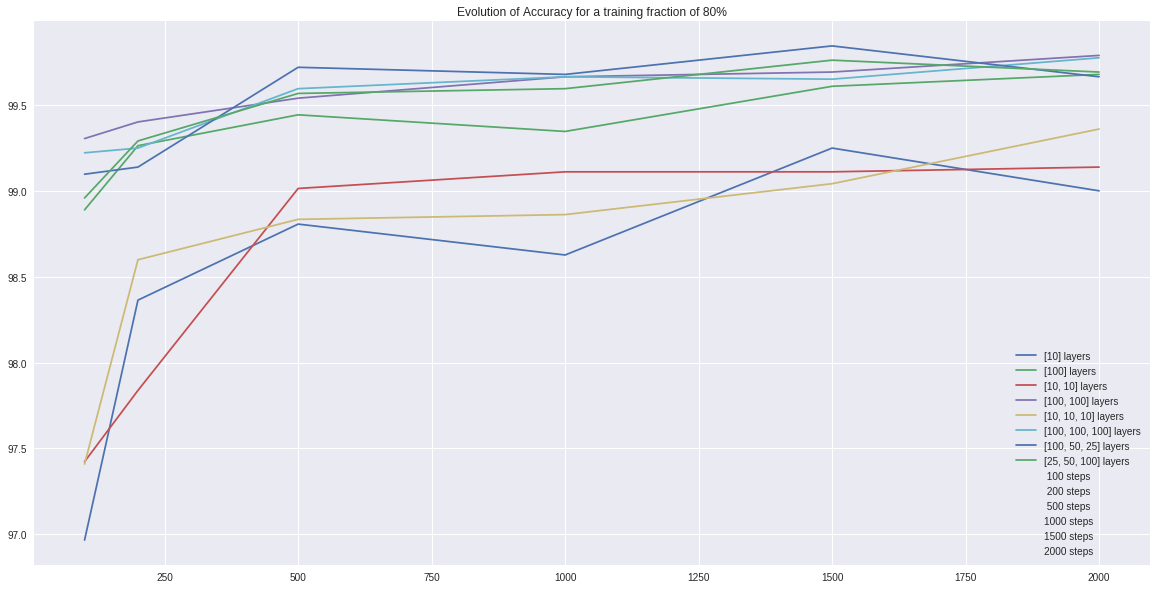

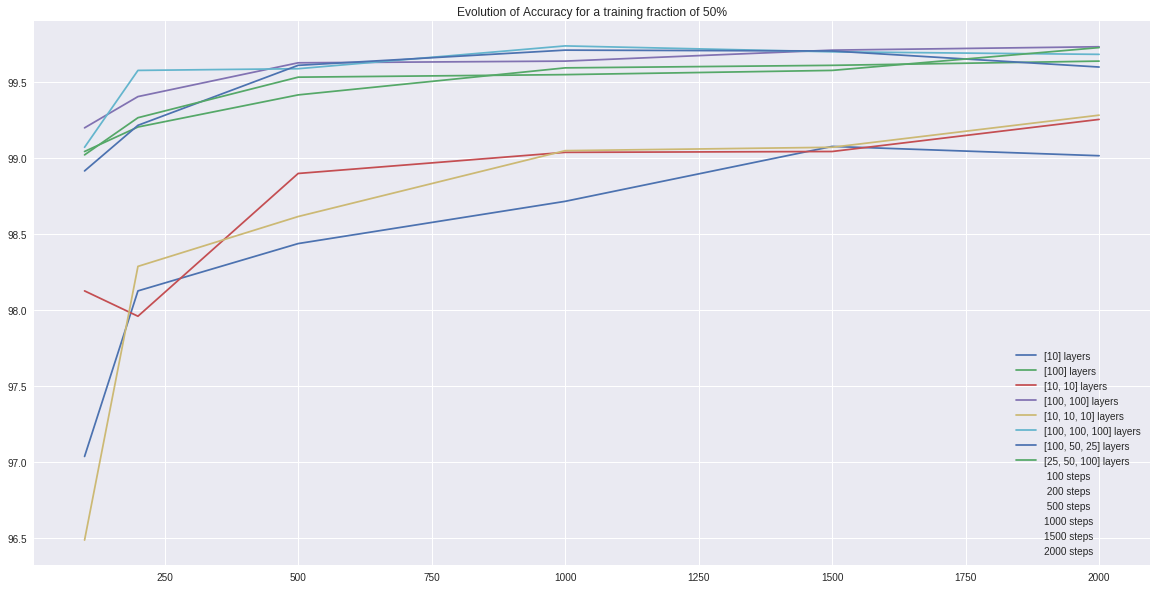

In [34]:
# k-fold Cross-validation data splitting results
display_model_results(kfcv_evaluations)

# Conclusion
The architectural choices of a **Neural Network** are of tremendous importance when designing such a network and its model, including the architecture, the way the data is split and fed into it, the number of times said data goes through the forward and backpropagation mechanisms. 

With our approach we have observed that, for instance, a **Neural Network** with a single layer comprised of 100 nodes, for our dataset, can better describe (without overfitting) the data then a network with two hidden layers of 10 neurons each.

## Other

### Deletes temporary files created by TensorFlow

In [0]:
# Allows deleting models save folder in windows
tf.summary.FileWriterCache.clear()

In [0]:
import tempfile
import os
from pathlib import Path
import shutil

temp_dir = Path(tempfile.gettempdir())
dir_list = [f for f in temp_dir.glob('tmp*') if f.is_dir()] 
for dir in dir_list:
    shutil.rmtree(dir, ignore_errors=True)
        